In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
# for visualitation import datetime
import datetime

In [3]:
def standardize(tx):
    mean = np.mean(tx, axis=0)
    std = np.std(tx, axis=0)
    tx = (tx-mean)/std
    return tx

# First : exploring the data

We'll need to have a look at what the data is, how it is distributed for the different features, and start to get an intuition about what methods might work better for analysis and prediction later.

## Load the training data into feature matrix, class labels, and event ids:

In [4]:
from proj1_helpers import *

# loading train data
DATA_TRAIN_PATH = 'data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [5]:
# remove samples with error values
idx_c = np.all(tX!=-999, axis=1)
y_c = y[idx_c]
tX_c = tX[idx_c]

# regularize
mean = np.mean(tX_c, axis=0)
std = np.std(tX_c, axis=0)
tX_c = (tX_c-mean)/std # tX.c contains data without samples with errors

# checking if features have errors or not
f=np.all(tX!=-999, axis=0)

# Removing features with errors (-999)
tX_fc = tX_c[:,f]

# adding column of 1 at the beginning of tX_fc
tX_fc= np.hstack(( np.ones((tX_fc.shape[0], 1), dtype=tX_fc.dtype),tX_fc)) 

In [6]:
# Describing features: True-> No error False -> At least one error
f

array([False,  True,  True,  True, False, False, False,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False,  True])

In [7]:
print(f[22],any(tX[:,22]>3)==True) 
# This shows that the features number of jets has no errors and only four possible values: 0,1,2,3

True False


Overall: s:  85667 , b:  164333  ,total: 250000
NoErrors: s:  31894 , b:  36220  ,total: 68114


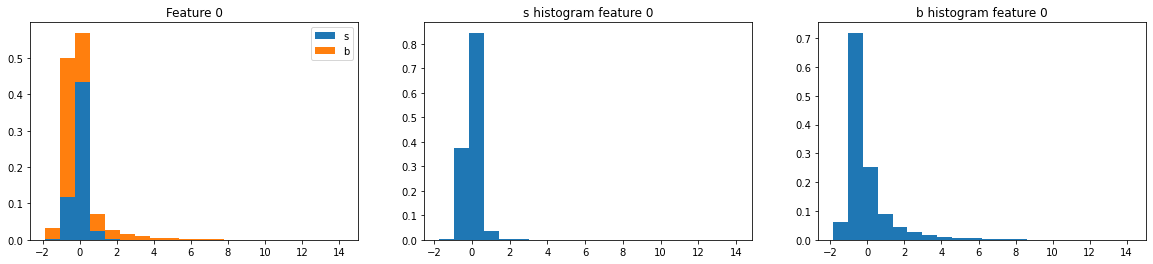

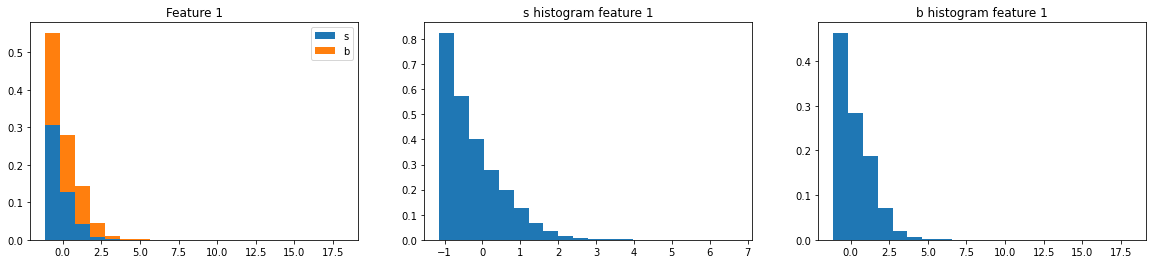

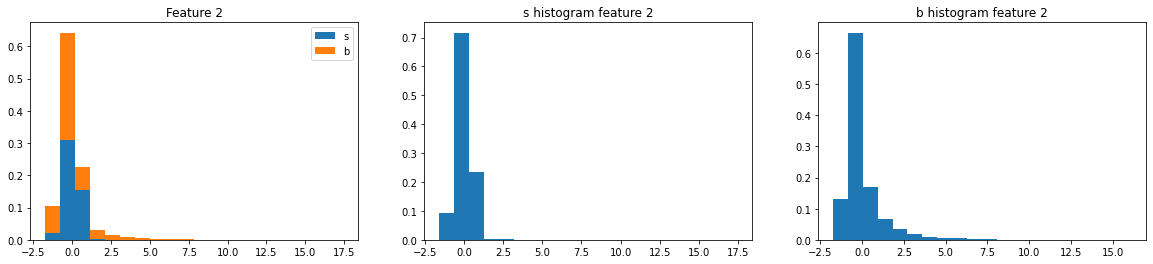

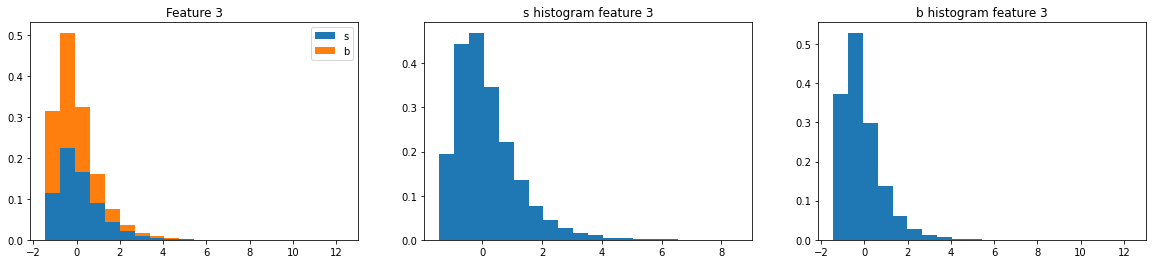

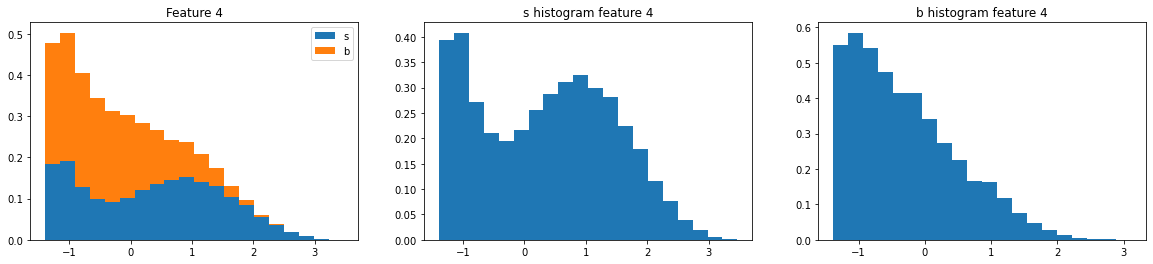

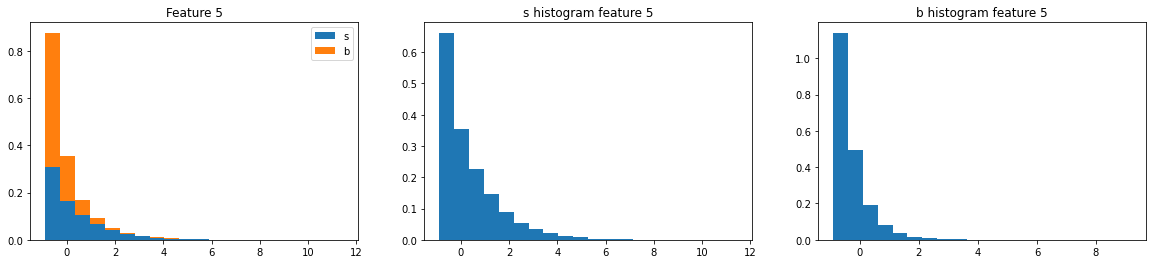

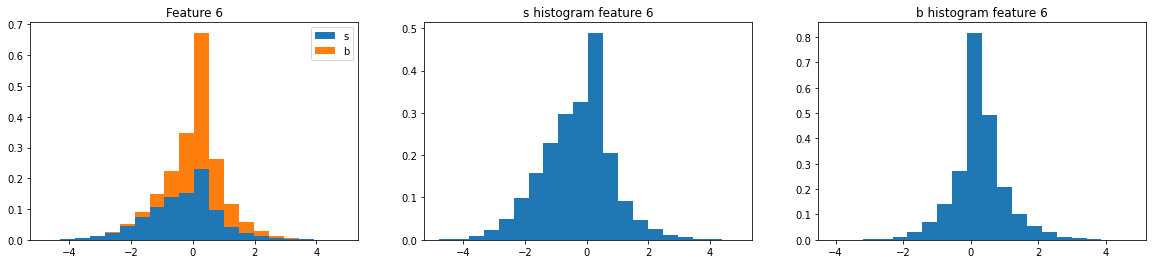

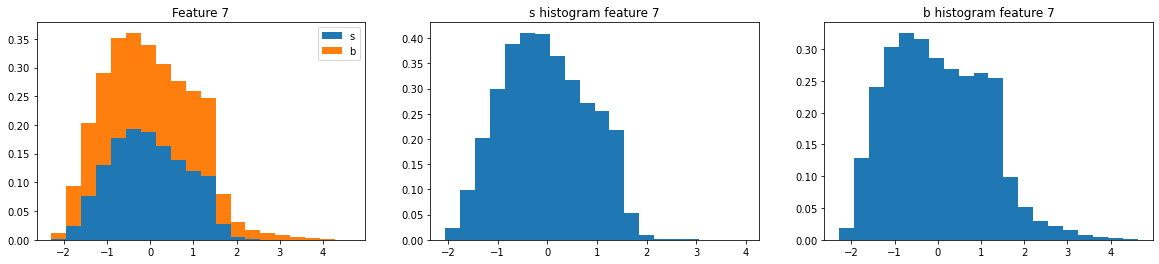

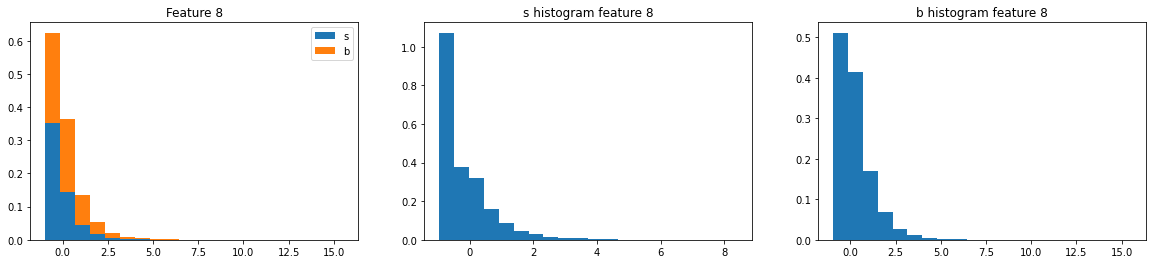

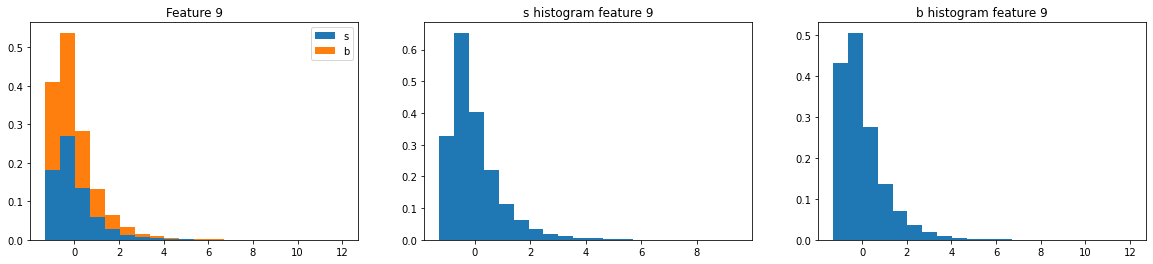

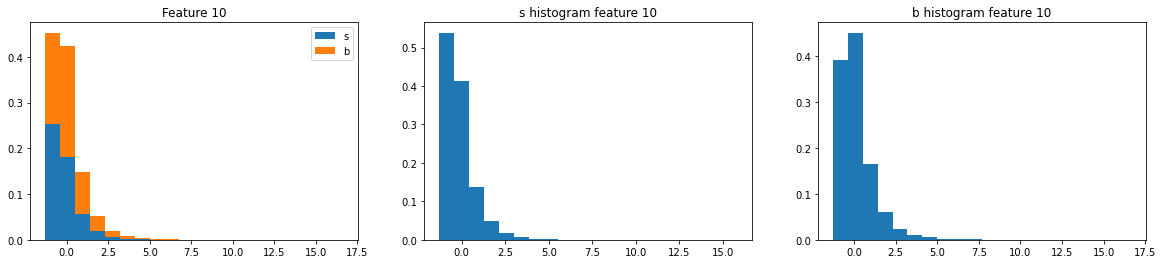

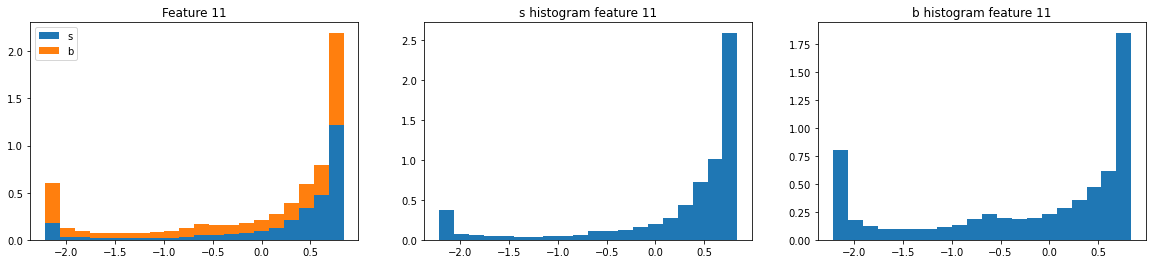

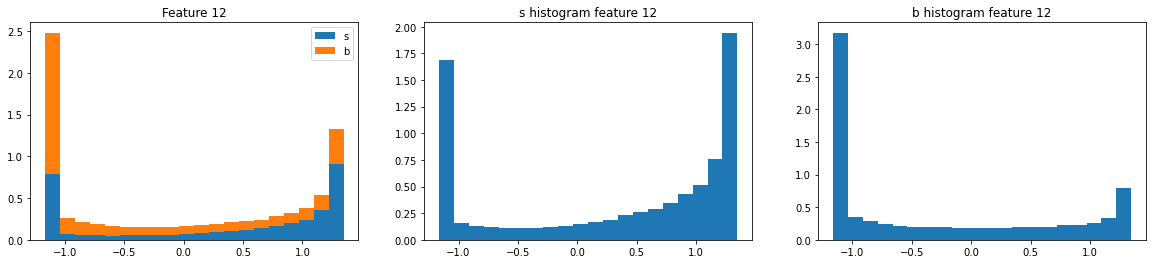

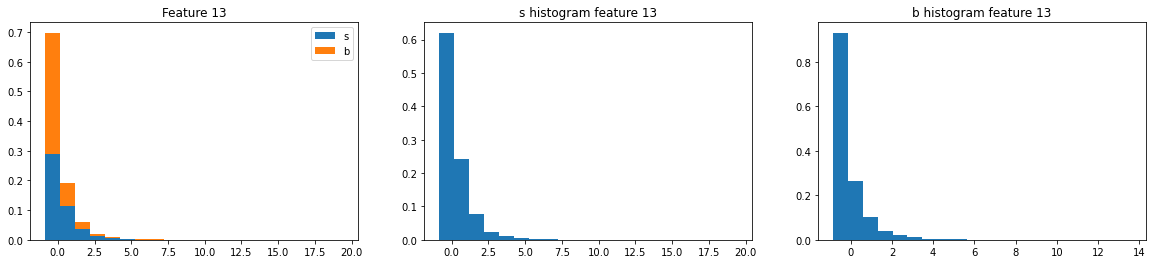

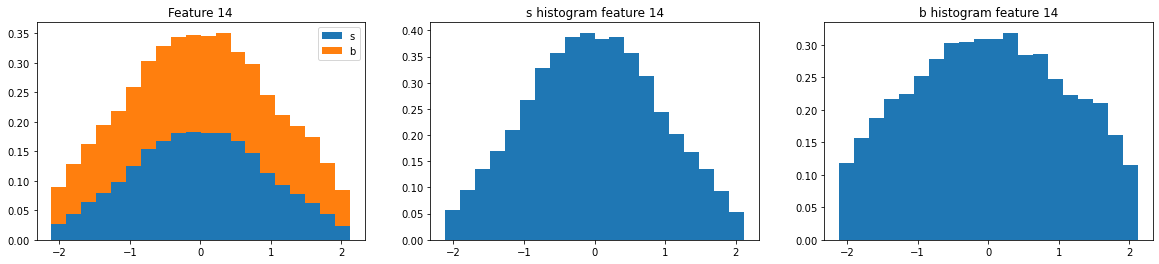

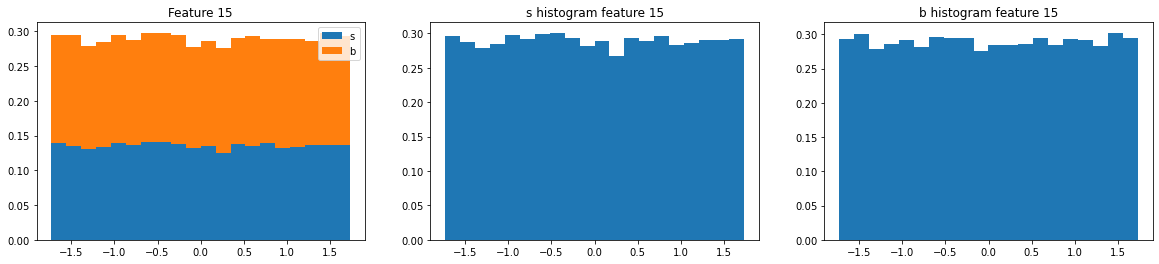

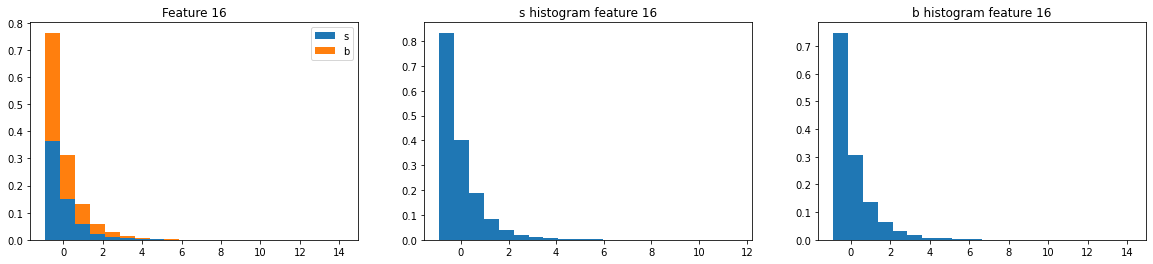

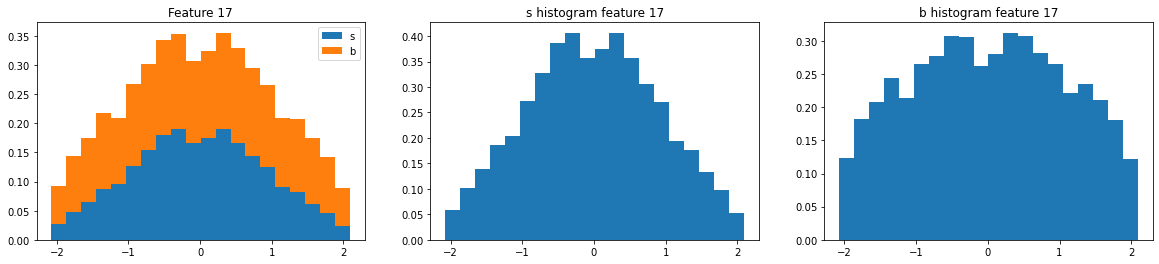

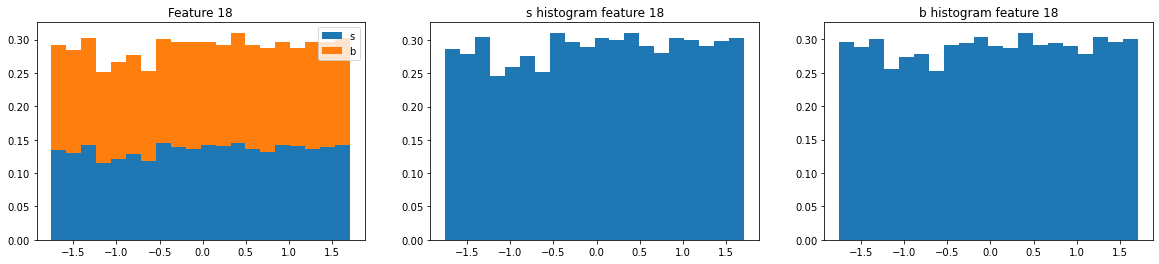

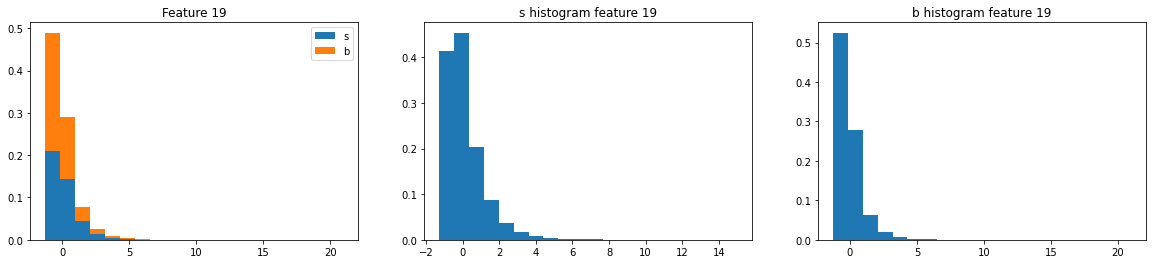

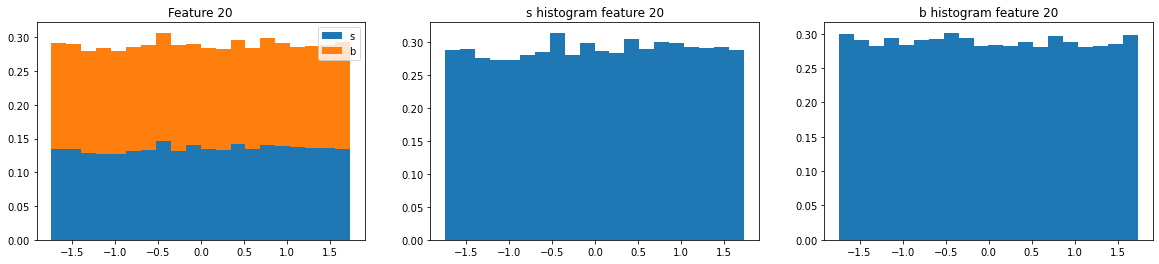

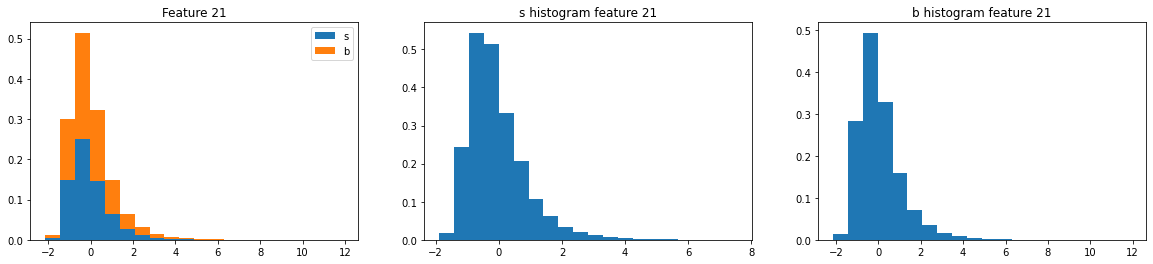

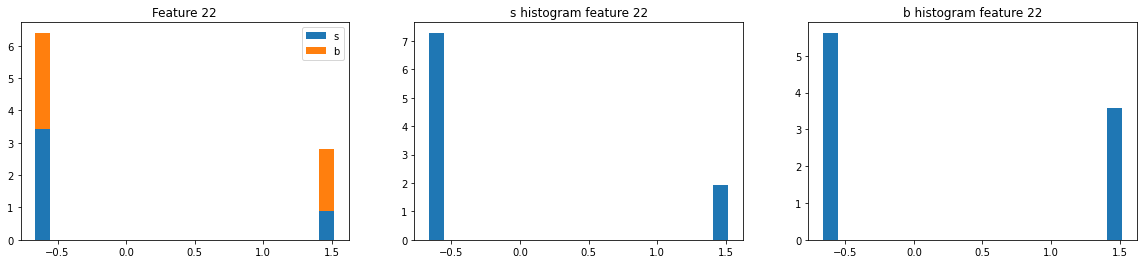

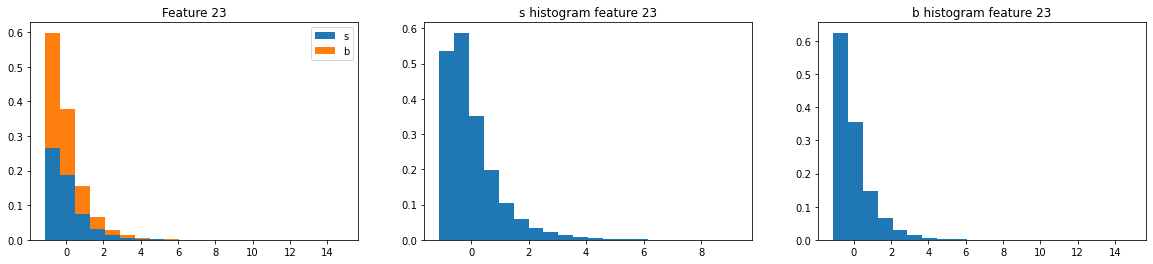

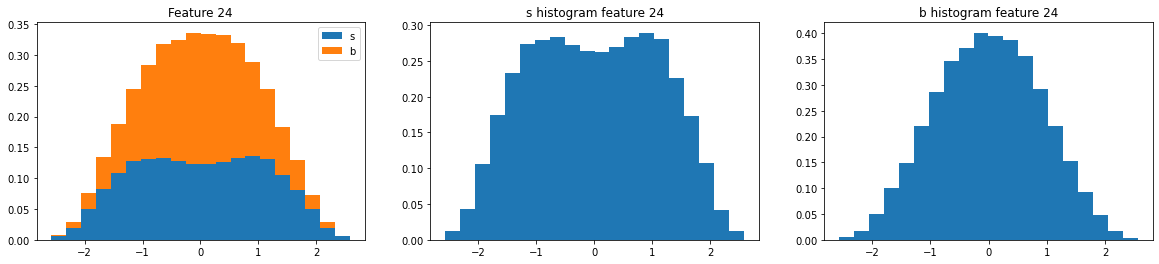

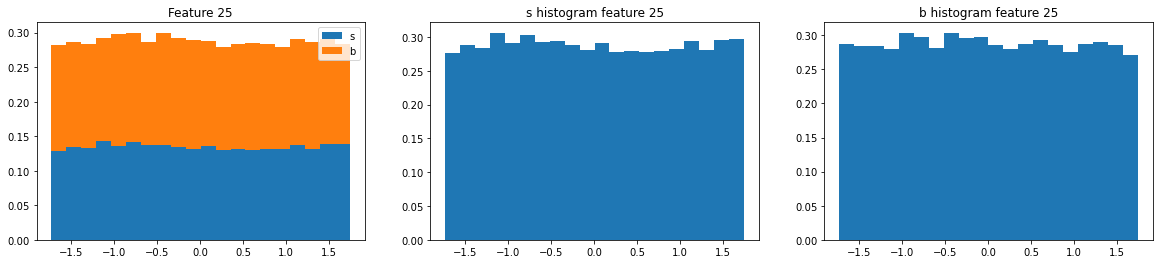

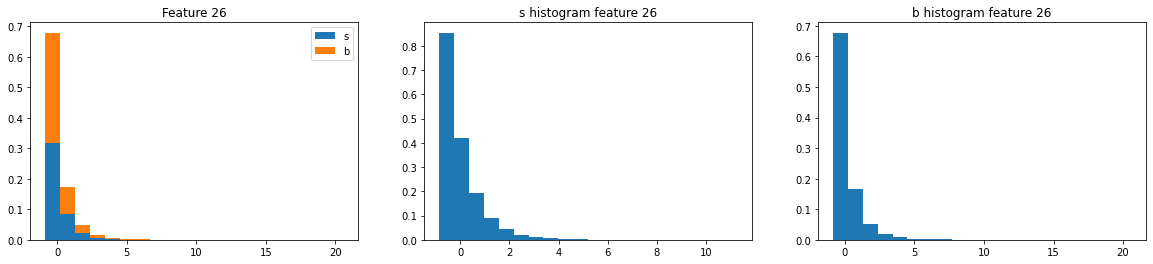

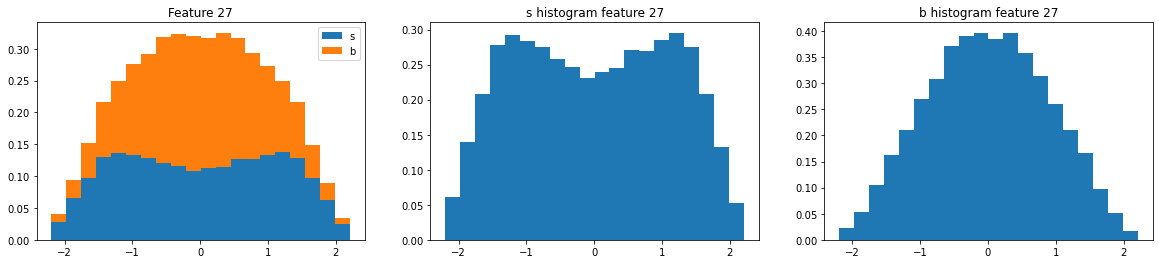

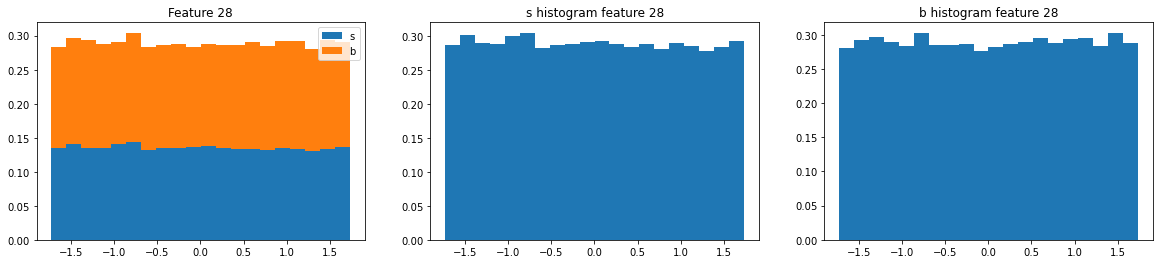

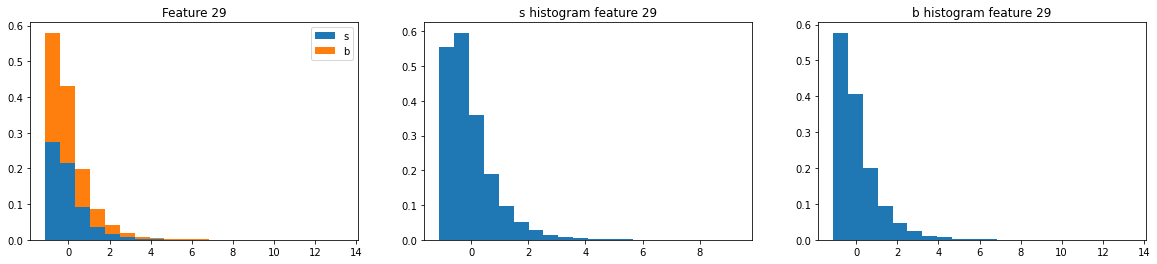

In [8]:
#plot of all features
print("Overall: s: ",np.sum(y==1),", b: ",np.sum(y==-1)," ,total:",len(y))
print("NoErrors: s: ",np.sum(y_c==1),", b: ",np.sum(y_c==-1)," ,total:",len(y_c))
for n in range(tX_c.shape[1]):
    plt.figure(figsize=(20,4))
    plt.subplot(131)
    plt.hist([tX_c[y_c==1,n],tX_c[y_c==-1,n]], 20, density=True, histtype='bar', stacked=True)
    plt.legend(['s','b'])
    plt.title('Feature '+str(n))
    plt.subplot(132)
    plt.title('s histogram feature '+str(n))
    plt.hist(tX_c[y_c==1,n], 20, density=True, histtype='bar', stacked=True)
    plt.subplot(133)
    plt.title('b histogram feature '+str(n))
    plt.hist(tX_c[y_c==-1,n], 20, density=True, histtype='bar', stacked=True)    
    plt.show()

In [9]:
# remove features with error values
idx_gf = np.arange(tX.shape[1])[np.all(tX!=-999, axis=0)]
y_gf = y
tX_gf = tX[:,idx_gf]
# regularize
mean = np.mean(tX_gf, axis=0)
std = np.std(tX_gf, axis=0)
tX_gf = (tX_gf-mean)/std

Overall: s:  85667 , b:  164333  ,total: 250000


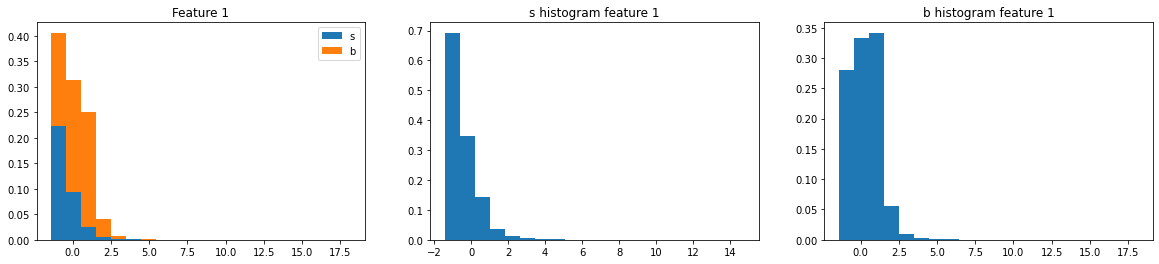

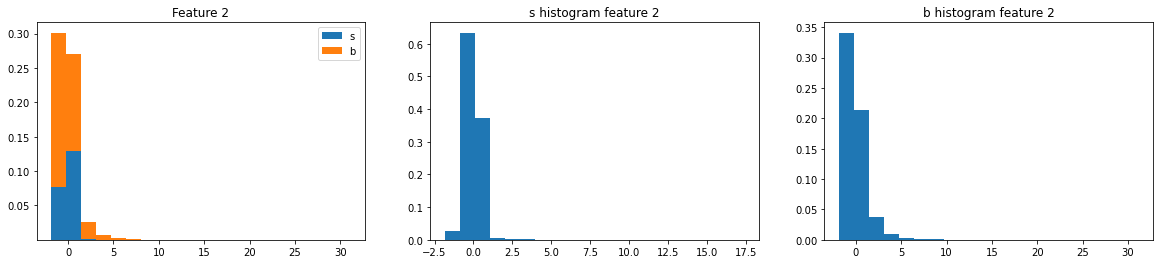

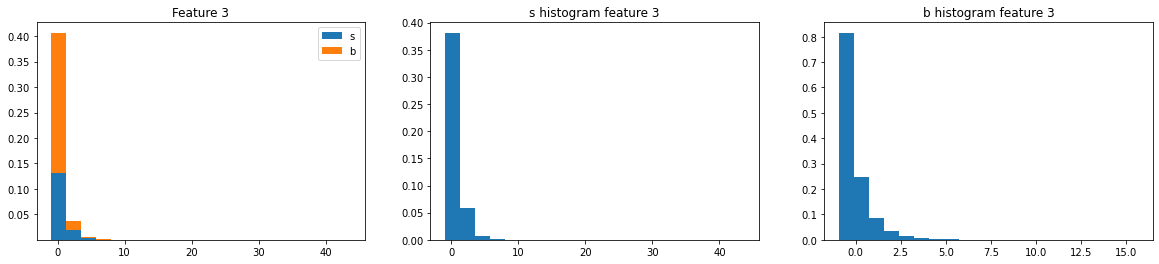

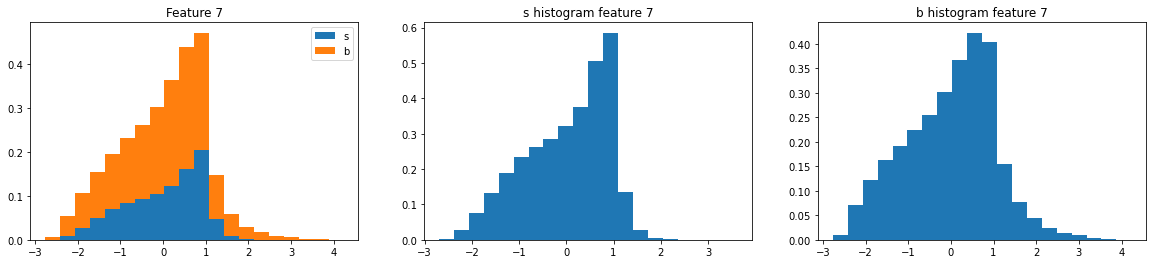

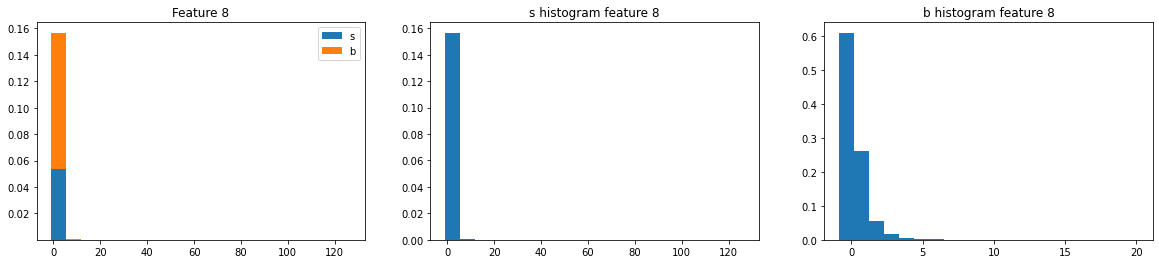

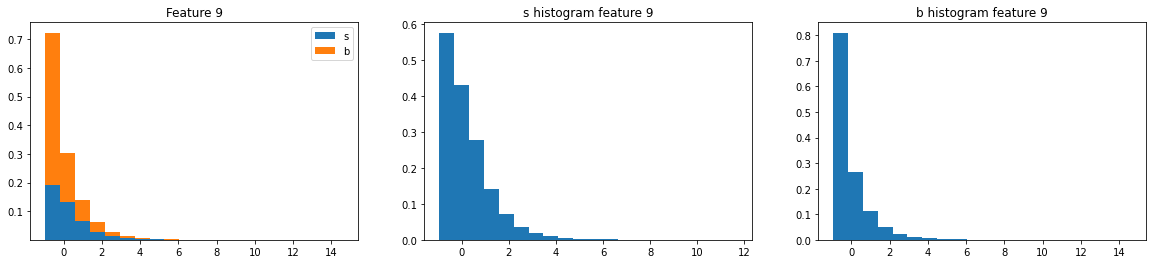

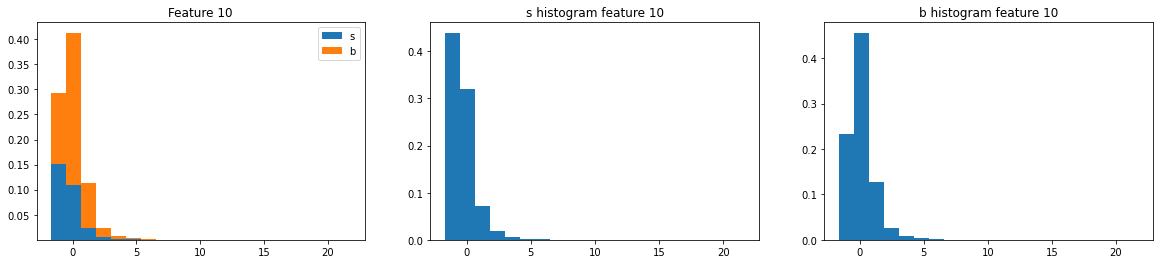

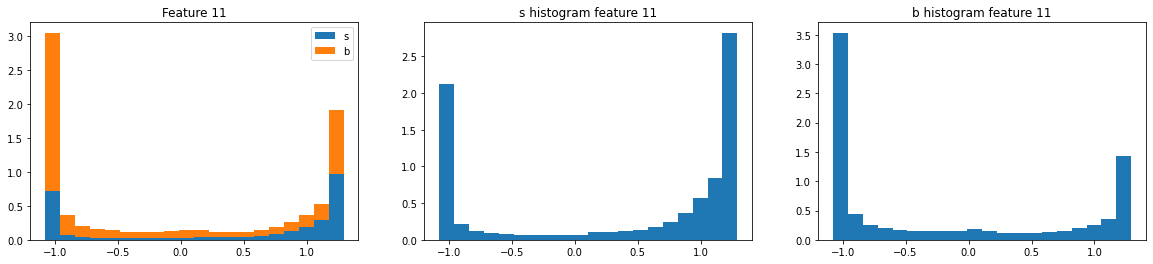

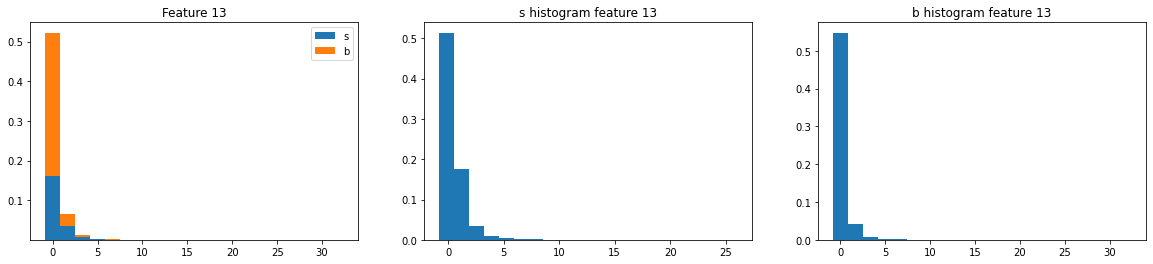

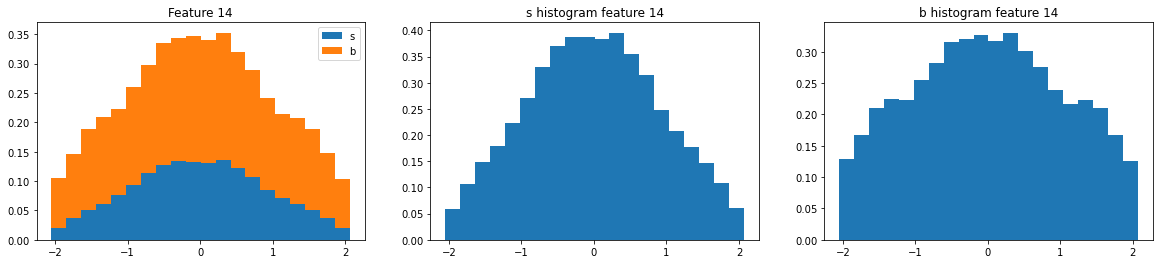

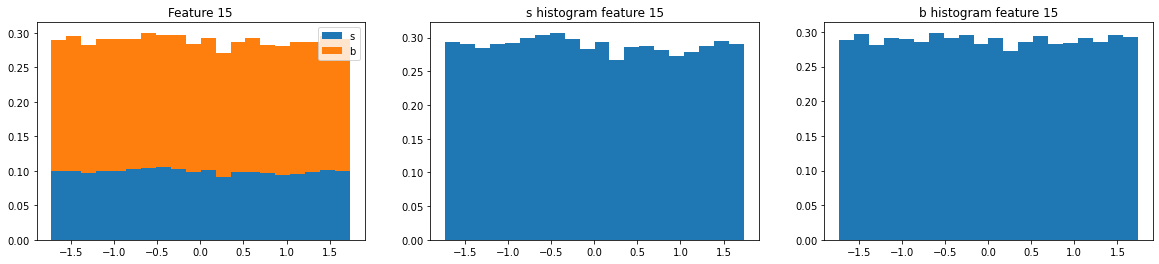

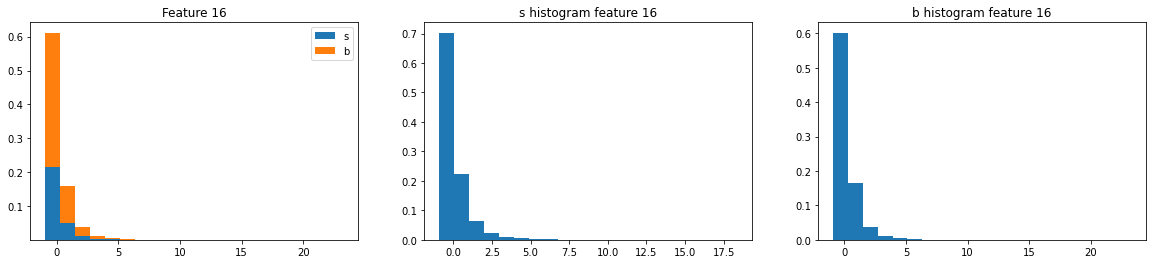

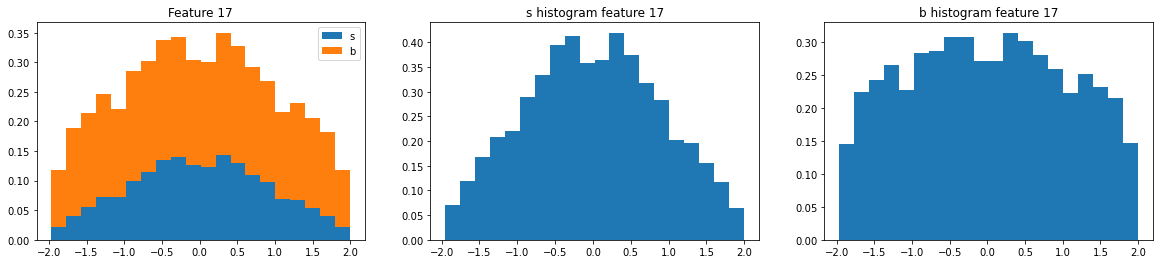

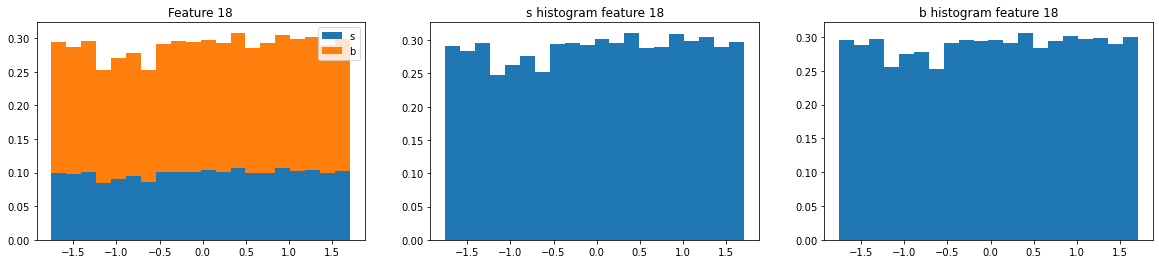

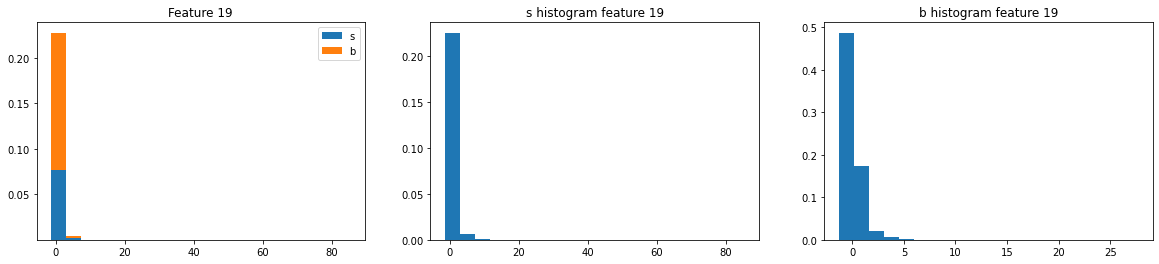

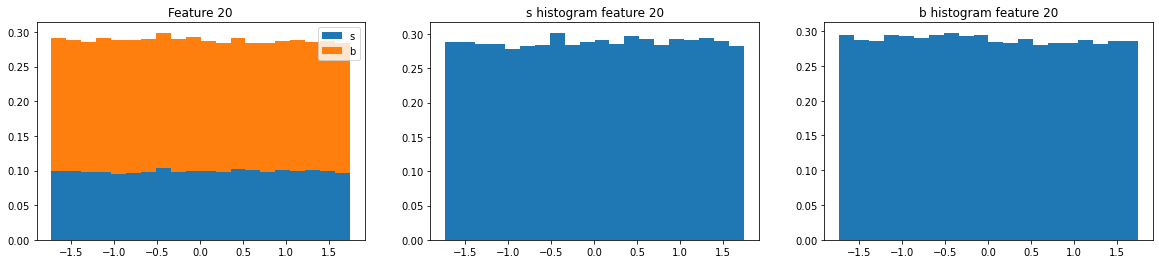

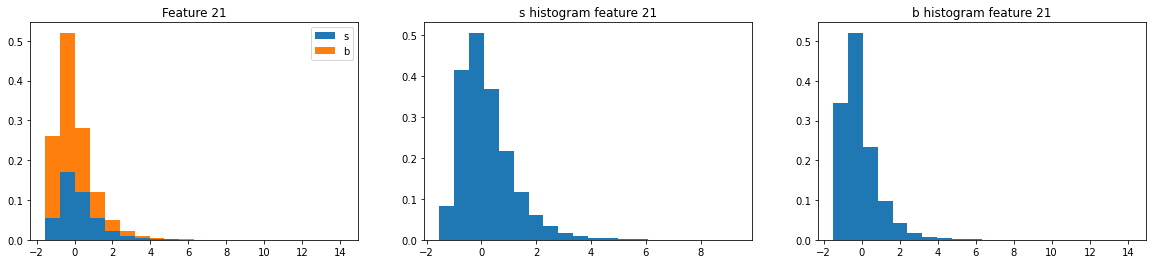

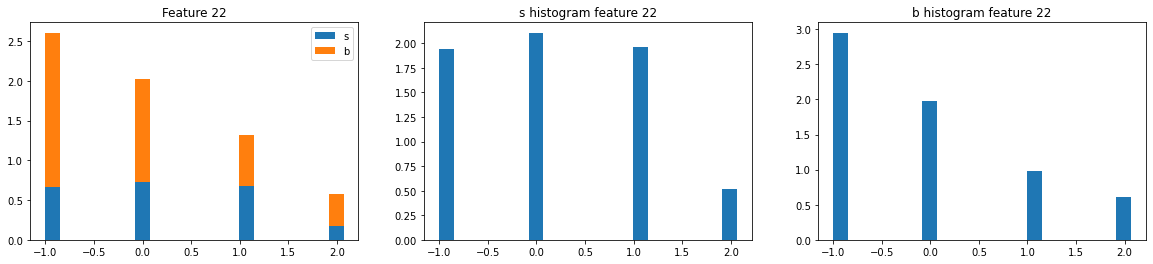

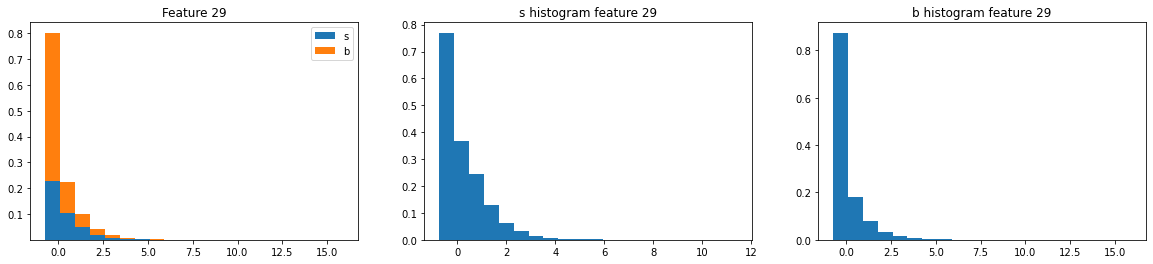

In [10]:
# plot of features without errors
print("Overall: s: ",np.sum(y==1),", b: ",np.sum(y==-1)," ,total:",len(y))
for n in range(tX_gf.shape[1]):
    plt.figure(figsize=(20,4))
    plt.subplot(131)
    plt.hist([tX_gf[y_gf==1,n],tX_gf[y_gf==-1,n]], 20, density=True, histtype='bar', stacked=True)
    plt.legend(['s','b'])
    plt.title('Feature '+str(idx_gf[n]))
    plt.subplot(132)
    plt.title('s histogram feature '+str(idx_gf[n]))
    plt.hist(tX_gf[y_gf==1,n], 20, density=True, histtype='bar', stacked=True)
    plt.subplot(133)
    plt.title('b histogram feature '+str(idx_gf[n]))
    plt.hist(tX_gf[y_gf==-1,n], 20, density=True, histtype='bar', stacked=True)    
    plt.show()

# Actual predictions start from here

After having looked at the data we will now do some actual predictions using different models andd parameters. 
Feature 15 ,18, 20 does not seem to impact the result.

In [11]:
# Splitting samples according to number of jets (featuare 23) 
# Only four possible values for jets (3 indicates also more jets)
jet_0 = tX[:,22]==0
jet_1 = tX[:,22]==1
jet_2 = tX[:,22]==2
jet_3 = tX[:,22]==3

#Splitting tX and y
tX_0 = tX[jet_0, :]
tX_1 = tX[jet_1, :]
tX_2 = tX[jet_2, :]
tX_3 = tX[jet_3, :]
y_0 = y[jet_0]
y_1 = y[jet_1]
y_2 = y[jet_2]
y_3 = y[jet_3]

#Removing column with jet number
tX_0=np.delete(tX_0,22,1)
tX_1=np.delete(tX_1,22,1)
tX_2=np.delete(tX_2,22,1)
tX_3=np.delete(tX_3,22,1)

# selection of features without errors in every partition of tX
f_0 =np.all(tX_0!=-999, axis=0)
tX_0_gf = tX_0[:,f_0]
f_1 =np.all(tX_1!=-999, axis=0)
tX_1_gf = tX_1[:,f_1]
f_2 =np.all(tX_2!=-999, axis=0)
tX_2_gf = tX_2[:,f_2]
f_3 =np.all(tX_3!=-999, axis=0)
tX_3_gf = tX_3[:,f_3]
tX_3_gf.shape[0] + tX_2_gf.shape[0] + tX_1_gf.shape[0] + tX_0_gf.shape[0]

250000

In [12]:
#Removing last column of tX_0_gf 
tX_0_gf = tX_0_gf[:,0:tX_0_gf.shape[1]-1]

In [13]:
# Standardize data
tX_0_gf = standardize(tX_0_gf)
tX_1_gf = standardize(tX_1_gf)
tX_2_gf = standardize(tX_2_gf)
tX_3_gf = standardize(tX_3_gf)
tX_0_gf.shape

(99913, 17)

In [14]:
# function that add new features 
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=1 up to j=degree."""
    phi=np.zeros((x.shape[0],degree*x.shape[1]))
    for j in range(degree):
            phi[:,j*x.shape[1]:(j+1)*x.shape[1]]=x**(j+1)
    return phi

In [15]:
# Passing to polynomial regression of degree= 'degree'
degree = 7
tX_0_gf=build_poly(tX_0_gf, degree)
tX_1_gf=build_poly(tX_1_gf, degree)
tX_2_gf=build_poly(tX_2_gf, degree)
tX_3_gf=build_poly(tX_3_gf, degree)

In [16]:
# adding column of 1 at the beginning of tX_gf
tX_0_gf= np.hstack(( np.ones((tX_0_gf.shape[0], 1), dtype=tX_0_gf.dtype),tX_0_gf))
tX_1_gf= np.hstack(( np.ones((tX_1_gf.shape[0], 1), dtype=tX_1_gf.dtype),tX_1_gf))
tX_2_gf= np.hstack(( np.ones((tX_2_gf.shape[0], 1), dtype=tX_2_gf.dtype),tX_2_gf))
tX_3_gf= np.hstack(( np.ones((tX_3_gf.shape[0], 1), dtype=tX_3_gf.dtype),tX_3_gf))


In [17]:
from implementations_2 import *

# indices of samples with no errors
ids_=ids[idx_c]

In [18]:
# least_squares method 
w_ls_0, loss_ls_0 =least_squares(y_0,tX_0_gf)
w_ls_1, loss_ls_1 =least_squares(y_1,tX_1_gf)
w_ls_2, loss_ls_2 =least_squares(y_2,tX_2_gf)
w_ls_3, loss_ls_3 =least_squares(y_3,tX_3_gf)
loss_ls_0, loss_ls_1

(1.3764176015351903, 110.07686177845339)

In [19]:
# least square using SGD

# starting value for SGD method
w_in_0= np.zeros((tX_0_gf.shape[1],))
w_in_1= np.zeros((tX_1_gf.shape[1],))
w_in_2= np.zeros((tX_2_gf.shape[1],))
w_in_3= np.zeros((tX_3_gf.shape[1],))

# number of iterations for SGD method
max_iters=1000

# step-size of the method
gamma=0.01

# application of the method to the separated dataset
w_ls_SGD_0,_=least_squares_SGD(y_0,tX_0_gf, w_in_0, max_iters, gamma)


Stochastic Gradient Descent(0/999): loss=0.5, w=[-1.00000000e-02 -9.90762547e-03  1.75728125e-03 -1.53161677e-02
  7.65855618e-03 -1.53161678e-02 -6.32398116e-04  2.93613355e-03
  4.84597168e-03 -6.75189134e-04 -1.07331898e-02  1.13701353e-02
 -3.16547029e-04 -2.32911286e-03  1.45421353e-03 -2.10847116e-02
 -9.18523365e-03 -3.23363640e-03 -9.81610424e-03 -3.08803739e-04
 -2.34584993e-02 -5.86534828e-03 -2.34584995e-02 -3.99927377e-05
 -8.62088025e-04 -2.34834415e-03 -4.55880366e-05 -1.15201363e-02
 -1.29279977e-02 -1.00202022e-05 -5.42476674e-04 -2.11473700e-04
 -4.44565062e-02 -8.43685171e-03 -1.04564044e-03 -9.72542843e-03
  5.42655021e-05 -3.59294308e-02  4.49200994e-03 -3.59294314e-02
 -2.52913320e-06  2.53120558e-04  1.13800092e-03 -3.07805470e-06
 -1.23647810e-02  1.46993083e-02 -3.17186522e-07 -1.26348940e-04
  3.07527916e-05 -9.37352611e-02 -7.74944542e-03 -3.38122099e-04
 -9.63559024e-03 -9.53597493e-06 -5.50301188e-02 -3.44023105e-03
 -5.50301198e-02 -1.59941907e-07 -7.431957

Stochastic Gradient Descent(6/999): loss=3.291293157846946e+32, w=[ 2.52503975e+03  6.61414081e+02 -2.62571819e+03 -2.01792768e+03
 -2.76415684e+03 -2.01792768e+03 -2.39214538e+03  1.57172482e+03
 -1.39051233e+03 -2.44748380e+03  5.09489548e+03 -9.55703459e+02
 -1.30861248e+03  4.60252824e+03  1.57099068e+03  3.82893903e+02
 -3.64189633e+03 -2.63418041e+03  6.14101197e+01  2.62400937e+03
  1.42800322e+03  2.86263257e+03  1.42800321e+03  2.07311076e+03
  8.21428819e+02  4.63651279e+02  1.83193025e+03  9.66627813e+03
  2.90164759e+02  6.58277212e+02  8.16366769e+03  9.71159360e+02
 -1.38168936e+02  5.16226835e+03  2.42536768e+03  1.27490783e+02
 -2.64814572e+03 -1.13208976e+03 -3.01680061e+03 -1.13208976e+03
 -2.08473500e+03  7.06853113e+02 -6.95848981e+02 -3.22312505e+03
  1.89561636e+04  1.55058103e+01 -3.22821474e+02  1.44847964e+04
  6.05505355e+02 -2.29791038e+02 -7.33751234e+03 -2.62455364e+03
 -1.33320904e+02  2.64585874e+03  7.96144007e+02  3.15003299e+03
  7.96143998e+02  1.5593

 -1.81956712e+06 -2.51525506e+05  2.59796269e+05  6.32487710e+05]
Stochastic Gradient Descent(11/999): loss=1.3076066344658496e+34, w=[ 6.93132393e+07 -1.07784885e+08  1.69140227e+08 -7.92514169e+06
  3.48220867e+07 -7.92514146e+06  2.82543459e+08 -7.34625532e+07
 -2.81009551e+07  2.85895664e+08 -3.71567021e+07  8.96911848e+07
  1.57888836e+08 -5.72778141e+07 -3.96987243e+07 -5.16804539e+07
 -2.62695811e+07  1.37202668e+08  1.66549085e+08  4.11084549e+08
  6.74429771e+05  1.71775122e+07  6.74429717e+05  1.14835005e+09
  7.66431164e+07  1.23390265e+07  1.17346086e+09  2.04922776e+07
  1.15532873e+08  3.59776136e+08  4.59127088e+07  2.10309713e+07
  3.84571123e+07  9.89396467e+06  2.70582492e+08 -2.57446506e+08
  9.98457125e+08 -2.01083757e+05  8.57919857e+06 -2.01083751e+05
  4.66369877e+09 -8.10003292e+07 -3.08136775e+06  4.81721768e+09
 -1.02689427e+07  1.48687421e+08  8.18214915e+08 -3.89998475e+07
 -1.31556461e+07 -2.86278047e+07 -3.58273788e+06  5.33478963e+08
  3.97801520e+08  2.4

Stochastic Gradient Descent(16/999): loss=1.3408217972348266e+47, w=[-6.63232980e+11 -9.30529069e+11 -5.14953522e+11  4.46751784e+11
 -2.45611449e+11  4.46751782e+11 -1.13641747e+12 -4.60896277e+11
  3.28330337e+11 -3.36477606e+11 -1.03218978e+12 -7.92641513e+11
 -1.48435677e+12 -9.25503210e+11  3.05343657e+11 -1.72455851e+11
 -1.00368487e+12  3.66050162e+11 -1.28701747e+12 -3.87278734e+11
 -3.00371057e+11 -8.17678474e+10 -3.00371055e+11 -1.91139458e+12
 -3.20206266e+11 -1.66056448e+11 -1.59753231e+11 -1.58412510e+12
 -9.24261619e+11 -3.28280834e+12 -1.26278746e+12 -1.39518849e+11
 -3.79226400e+10 -1.48481648e+12 -1.89401054e+11 -1.78624039e+12
 -2.98888266e+11  1.99658906e+11 -4.02755240e+10  1.99658904e+11
 -3.23136584e+12 -2.21727730e+11  7.51363563e+10 -7.87254011e+10
 -2.43680329e+12 -1.10815344e+12 -7.26413547e+12 -1.74040668e+12
  6.17946179e+10 -1.33125499e+10 -2.24220116e+12  1.11565692e+11
 -2.47590256e+12 -2.23313412e+11 -1.38700455e+11  8.92669209e+09
 -1.38700453e+11 -5.44

  4.40206081e+12  1.02219391e+17  1.30392328e+16  3.57380942e+14]
Stochastic Gradient Descent(22/999): loss=5.078978416644915e+58, w=[ 2.41330225e+15 -1.57300482e+14 -4.53958137e+14 -1.55071754e+15
 -4.79717840e+14 -1.55071753e+15 -1.43339673e+15 -2.17233363e+14
 -1.16522634e+15 -1.08614896e+15  4.17346952e+14 -4.34514799e+14
 -1.18131985e+15 -2.19865197e+15  6.40751196e+14 -2.12260051e+14
  5.49358772e+14 -1.69429113e+15  9.46842295e+14  1.76900895e+15
  1.25922851e+15  4.30550284e+15  1.25922851e+15  1.52861388e+15
  1.62760948e+14  6.39447814e+14  1.27654155e+15  1.02195640e+15
  4.45118855e+15  8.10451875e+14  2.83792109e+15  3.90767020e+14
  2.22815622e+15  3.36932646e+15  4.23713184e+15 -1.83497220e+14
 -9.21782414e+14 -7.35558961e+14 -2.36861266e+15 -7.35558953e+14
 -9.33323227e+14 -1.32957716e+14 -3.14326209e+14  6.55354595e+14
  5.54660690e+14 -2.50454717e+15 -6.32728308e+14 -2.85584689e+15
  2.07967438e+14  2.94892114e+14  2.33369329e+15 -7.13646573e+15
  7.22327113e+14  1.55

Stochastic Gradient Descent(27/999): loss=3.1936787987057957e+59, w=[-3.70968804e+17  2.52911778e+17  9.53020366e+16 -1.66988146e+17
 -1.48177489e+17 -1.66988148e+17  9.45043322e+16  1.51962329e+17
 -3.78531566e+17  4.23734937e+16  2.95366020e+17 -2.73243257e+16
  1.08412535e+17  2.47591433e+17 -1.87048056e+17  7.13962213e+16
 -4.84471568e+17 -2.06547727e+17 -8.36062568e+17 -1.81100823e+17
 -8.78381942e+16 -1.28278957e+17 -8.78381959e+16 -2.54274055e+17
 -1.17641551e+17 -6.58735109e+17 -5.94973593e+16 -2.99392003e+17
 -1.15662633e+17 -3.27820823e+17 -2.77474103e+17 -4.78361428e+17
 -1.01904075e+17 -5.54117007e+17 -2.73203256e+17  1.23043961e+18
 -1.13644000e+16 -4.68953446e+16 -3.89687643e+16 -4.68953459e+16
  6.16686741e+16  4.62421571e+16 -1.08138200e+18  1.61078713e+15
  2.78371208e+17 -6.79255421e+16  8.52034558e+16  3.00465074e+17
 -3.62738251e+17 -2.94456031e+16 -7.25832041e+17 -4.52846065e+17
 -2.50664868e+18 -2.20939350e+17 -3.13553776e+16 -1.25036011e+17
 -3.13553785e+16 -1.60

Stochastic Gradient Descent(32/999): loss=1.7907064577827078e+74, w=[ 3.21344426e+23  2.02303021e+23  3.00612258e+23 -1.77556021e+23
  1.33438395e+23 -1.77556020e+23  3.24635390e+23 -1.83898160e+22
 -1.43809133e+23  1.78599133e+23  1.93349664e+23 -5.47637746e+22
  3.37911507e+23  5.21830140e+23 -5.06849672e+23 -8.94151462e+21
  1.60074848e+23  3.68977592e+23  1.65738301e+23  2.78276690e+23
  8.59113667e+22  4.00735518e+22  8.59113658e+22  3.45786426e+23
 -3.21471346e+21  1.34224705e+23  1.10026737e+23  1.31360919e+23
  3.26799394e+21  3.61719537e+23  8.43078903e+23  8.89407718e+23
  1.37512435e+22  8.15377697e+22  4.24823766e+23  7.41852307e+22
  1.80304256e+23 -8.68870373e+22 -3.06840678e+22 -8.68870370e+22
  3.55651831e+23  5.55958826e+21  8.95058467e+22  6.17498748e+22
  7.00949631e+22 -7.70841453e+21  3.92616598e+23  1.40016363e+24
 -1.41023868e+24 -1.67575116e+22  4.33380382e+22  4.89078894e+23
  1.05938136e+23 -1.47877300e+23 -4.21582132e+22 -1.38510015e+23
 -4.21582149e+22  3.73

Stochastic Gradient Descent(37/999): loss=3.487291866711969e+85, w=[ 3.66769477e+31  2.10361335e+31  3.84808410e+31 -2.45218590e+31
  2.05307103e+31 -2.45218589e+31  3.58138067e+31  4.89819761e+30
 -1.90335462e+31  1.64320940e+31 -2.18190357e+31 -5.56481124e+29
  4.06937301e+31 -3.14834928e+31 -3.50682301e+31 -3.65459340e+30
  3.43726212e+31 -2.07584778e+31  1.22123498e+31  5.10928857e+31
  1.77288014e+31  1.34135502e+31  1.77288013e+31  7.15196551e+31
  3.44845644e+30  9.87806353e+30  2.66670315e+31  2.82405607e+31
  7.81714026e+30  7.22378100e+31  4.03274358e+31  5.11725781e+31
  4.74862375e+30  3.76089257e+31  2.21204292e+31  7.16214266e+30
  6.91869144e+31 -1.18845572e+31  8.23950450e+30 -1.18845571e+31
  9.91217496e+31  3.75835928e+30 -5.12683567e+30  1.33195918e+31
 -3.94495935e+31 -4.79646500e+30  1.12774568e+32 -4.74918869e+31
 -6.80506313e+31  3.82879432e+29  4.72201921e+31 -1.75837734e+31
  4.23374663e+30  9.41641080e+31  9.15988421e+30  5.98711085e+30
  9.15988412e+30  1.630

Stochastic Gradient Descent(42/999): loss=3.7671404358271093e+89, w=[ 3.57325097e+34  9.44241938e+33 -1.61612412e+34  3.63968619e+34
 -3.02961089e+34  3.63968622e+34 -9.05569545e+33 -4.42050530e+34
 -1.36844144e+34  1.78761060e+34 -6.41624162e+34 -1.55826443e+34
 -3.32923084e+34 -3.19675500e+34 -3.55642122e+34  3.64107695e+34
  2.45782996e+34  2.58638928e+34  2.73158552e+34  8.15884147e+33
  4.12897979e+34  3.87135645e+34  4.12897983e+34  5.53577719e+32
  4.89770189e+34  5.34005528e+33  5.54041050e+33  1.14079750e+35
  7.05120704e+33  2.90252108e+34  2.78269609e+34  7.58025927e+34
  5.02560824e+34  2.30954850e+34  1.84145739e+34 -1.87541288e+34
 -5.90359035e+33  4.79388446e+34 -3.91238506e+34  4.79388454e+34
 -6.22486717e+33 -6.08103731e+34 -2.10713432e+33 -4.09761006e+33
 -2.23341329e+35 -2.78506145e+33 -2.74867886e+34 -3.52602788e+34
 -7.13924800e+34  6.13118635e+34  2.77412641e+34  1.75264425e+34
  4.67461328e+34  1.85948964e+33  5.47490513e+34  4.55291859e+34
  5.47490525e+34 -9.68

  6.51532014e+38 -2.37967875e+37 -3.28533982e+39 -1.66594684e+39]
Stochastic Gradient Descent(47/999): loss=6.297143471768447e+100, w=[-9.25599628e+38  7.32489752e+38 -2.77830757e+38  5.47306947e+38
 -9.58023895e+37  5.47306945e+38 -6.52447446e+38  9.25866909e+38
  4.66641066e+38 -1.27963528e+39  5.07122455e+38 -7.08003478e+38
  2.82182368e+38  6.11388693e+38  4.37286128e+38  1.41498080e+38
 -1.26291817e+38 -4.95855751e+38 -1.25235357e+39  1.37273672e+38
 -2.60670587e+38 -6.16117637e+37 -2.60670584e+38 -6.30974181e+38
 -1.46552359e+39 -2.35401132e+38 -2.50661294e+39 -6.70500453e+38
 -1.37306433e+39 -3.02154143e+37 -8.40794733e+38 -2.95799188e+38
 -2.99806976e+38 -3.49988015e+38 -4.81761837e+38  1.42703834e+39
  1.08106882e+39  1.44117924e+38  1.76675592e+38  1.44117922e+38
 -5.53841676e+38  1.93249846e+39  1.18816295e+38 -4.09524640e+39
  3.78533788e+37 -1.40640040e+39 -5.46661248e+37  8.42321158e+38
  2.54275966e+38  9.63919972e+36 -5.59058012e+38 -4.72297842e+38
 -1.88476469e+39  6.3

Stochastic Gradient Descent(52/999): loss=1.5585778422474107e+112, w=[-1.97977859e+44 -2.74829077e+44 -2.93399978e+44 -1.68071886e+44
 -7.08942187e+43 -1.68071887e+44 -9.00885770e+43  6.64586216e+43
  7.42714370e+43 -7.27279451e+43 -2.79844600e+43  2.41234424e+44
 -6.95852436e+43  2.93203915e+44 -2.28786189e+44 -2.54405445e+44
  7.06739149e+43 -1.59649411e+44 -3.84033197e+44 -4.98730546e+44
 -1.57446802e+44 -7.31509871e+43 -1.57446804e+44 -5.81942320e+43
 -1.01018007e+43 -2.82369336e+43 -3.62041271e+43 -1.52180253e+43
 -2.93704746e+44 -2.82341309e+43 -4.39918637e+44 -2.64806297e+44
 -3.27424686e+44 -2.60067765e+43 -1.28968138e+44 -5.34623903e+44
 -7.52867824e+44 -1.40996283e+44  4.40882344e+43 -1.40996286e+44
 -1.92008275e+43  1.82928033e+43  9.74464948e+42 -9.60647203e+42
  6.24596607e+42  3.57491668e+44  8.42961971e+42  6.62694204e+44
 -3.07072563e+44 -4.21652507e+44  9.62049414e+42 -9.97427415e+43
 -7.34590847e+44 -1.24114954e+45 -1.28518555e+44 -1.25727408e+44
 -1.28518559e+44 -1.8

  9.04967293e+47  1.09088616e+47  1.53398183e+44 -1.01540008e+47]
Stochastic Gradient Descent(57/999): loss=5.449278178994632e+117, w=[ 3.85612758e+48 -3.93743100e+48 -1.43799548e+47  1.19621829e+48
  2.60886897e+48  1.19621831e+48  7.55861181e+47 -4.28169142e+48
 -2.05136307e+48  3.34978078e+48 -1.72678015e+48  5.25996040e+48
 -2.27686823e+48 -5.22806895e+47 -1.18185829e+48 -4.12258291e+47
  3.41495758e+47  5.46352204e+48  5.18826419e+48  2.90947828e+46
  4.94580864e+47  1.76435525e+48  4.94580875e+47  2.23369410e+47
  6.50803514e+48  1.10027916e+48  3.15815935e+48  8.05321526e+47
  7.48779632e+48  2.31174045e+48  6.35234650e+46  6.92296904e+47
  1.93239074e+47  5.72355401e+46  8.44868140e+48 -4.23620280e+48
  6.63826849e+45  1.09278693e+47  1.19258705e+48  1.09278699e+47
  1.33606842e+47 -4.74572806e+48 -5.78145115e+47  2.83074605e+48
 -4.40116466e+47  1.05806711e+49  8.21770302e+46 -1.96025354e+46
  1.12993412e+47  1.07494767e+47 -2.08252045e+45  1.23326771e+49
  7.92013772e+48  1.9

Stochastic Gradient Descent(64/999): loss=3.3909384941850135e+142, w=[-7.51775164e+59 -3.88600118e+59 -4.38302176e+59  5.03044391e+59
 -1.69548209e+59  5.03044389e+59  1.07184604e+59  1.54379299e+59
  3.91354655e+59  9.38576323e+58  1.21785550e+60  5.66544137e+59
  7.51981894e+58 -1.39705886e+58 -1.15373563e+60 -3.12890006e+59
 -2.17181847e+59  4.53407560e+59 -2.02755827e+59 -1.28050351e+59
 -3.35682883e+59  1.17620840e+59 -3.35682881e+59  3.50999414e+58
 -3.17921137e+58 -2.03725042e+59  1.38451417e+58 -1.79519543e+60
 -3.96873142e+59  3.04222978e+58  1.10069499e+59 -1.78927352e+60
 -1.22496754e+59 -6.70637434e+58 -2.70135713e+59 -1.04227626e+59
 -1.53274075e+59  2.23197174e+59 -1.91218466e+59  2.23197172e+59
 -8.51301572e+58  6.67474571e+57  1.06049820e+59 -3.00951168e+58
  2.68491318e+60  1.94269875e+59 -5.73127798e+58  1.77008004e+59
 -2.76022947e+60 -3.51599366e+58 -2.37054598e+58  1.26181910e+59
 -5.47889958e+58 -1.51718895e+58 -1.47720190e+59  2.73829157e+59
 -1.47720188e+59  9.6

Stochastic Gradient Descent(70/999): loss=1.2852331211059678e+148, w=[-8.48131714e+61 -2.85462331e+61  1.17704092e+62  4.57961141e+61
  1.51415802e+62  4.57961139e+61  1.06561717e+62  1.86232481e+61
  7.40179525e+61  7.46966796e+61  2.48222234e+61  7.59634996e+61
  9.41391319e+61 -2.60052946e+61  9.83621043e+61 -6.69991291e+61
 -8.42877797e+61  1.17353519e+62 -9.50586777e+60 -1.42341694e+62
 -1.11453366e+61 -3.14194898e+62 -1.11453363e+61 -1.04220179e+62
 -6.68951047e+59  2.80766895e+61 -5.17039844e+61 -5.15247864e+61
 -1.83524166e+62 -7.74499833e+61 -1.07752047e+61 -7.43543968e+61
 -7.07831980e+61 -9.36210215e+60 -1.08321805e+62 -2.81321565e+60
  2.05999879e+62  1.42135161e+61  6.33972687e+62  1.42135161e+61
  1.27987724e+62  9.73229123e+60  1.36240553e+62  4.30850128e+61
  2.78646691e+60  1.86889534e+62  1.01540178e+62 -3.06922947e+61
  8.60065143e+61 -6.66349536e+61 -8.27494200e+61  1.43763586e+62
  8.19694535e+59 -2.45405593e+62 -2.13906197e+60 -1.26206131e+63
 -2.13906179e+60 -1.4

 -1.52185436e+67 -1.00763215e+65 -1.78387791e+67 -1.49560722e+64]
Stochastic Gradient Descent(76/999): loss=4.336604486945228e+160, w=[-7.48421787e+66 -3.96981952e+66 -2.40544312e+66  2.64740930e+66
  6.92211405e+65  2.64740928e+66 -7.26493284e+66 -1.75788176e+66
  6.71612028e+65 -2.64546891e+66 -6.28350364e+66  5.79148197e+66
 -8.97251317e+66 -8.26759859e+66 -4.63731999e+66 -3.13427292e+65
  1.19387490e+67  5.49272414e+66 -8.57429640e+66 -1.60006225e+66
 -5.84412383e+66  1.12465426e+66 -5.84412384e+66 -7.60005049e+66
 -3.01699696e+65 -6.39804860e+66 -1.47821250e+66 -8.03223219e+66
 -5.15649499e+66 -1.06604237e+67 -1.44634154e+67 -3.52210428e+66
 -3.40170511e+65 -2.24687596e+67 -5.62655441e+66  3.73962237e+66
 -5.41562392e+65 -1.39635165e+66  1.29058788e+66 -1.39635172e+66
 -7.60561564e+66 -6.71649046e+64 -8.59927828e+66 -4.13186592e+65
 -5.45059014e+66  3.43925977e+66 -1.28235552e+67 -1.94349534e+67
 -4.02685385e+66  1.91196552e+65  3.33239362e+67  4.91570963e+66
 -1.62698184e+67 -3.2

 -7.72925962e+72 -2.65378602e+75  2.61147779e+72 -3.45107469e+71]
Stochastic Gradient Descent(81/999): loss=4.327360519080551e+175, w=[-1.17579611e+73  3.06607434e+72 -6.02795692e+72  4.43937633e+72
 -1.16238182e+73  4.43937629e+72 -7.66002594e+72 -1.95577354e+72
 -3.06849130e+73 -2.46808992e+72 -5.63388499e+72  1.55984013e+73
 -9.79651089e+72  2.77987417e+72 -9.18805744e+72  1.13852741e+73
  1.36609378e+73 -1.56278256e+73 -4.46141979e+71 -2.78919995e+72
 -3.36649569e+72 -1.02975152e+73 -3.36649567e+72 -4.31310010e+72
 -1.48592885e+72 -7.40074608e+73 -1.49885383e+72 -1.94471079e+72
 -1.35927008e+73 -8.69002386e+72 -3.82788370e+71 -2.70274728e+72
 -1.45365451e+73 -1.51537568e+73 -1.56726770e+73 -1.11171356e+71
 -1.29457210e+72 -1.74687651e+72 -8.36567573e+72 -1.74687656e+72
 -2.56972390e+72  1.44649563e+72 -1.81346951e+74 -3.22387392e+72
  4.08130442e+72  1.90045961e+73 -6.37653977e+72 -1.76456682e+71
 -5.57394320e+72 -4.50847136e+72  1.61381853e+73 -1.93867279e+73
 -5.20550173e+71 -6.5

Stochastic Gradient Descent(86/999): loss=2.6240864838493094e+176, w=[ 1.17364507e+76  1.11323218e+76 -2.90347300e+75 -1.15029518e+76
 -1.21977054e+76 -1.15029518e+76  5.67326390e+75 -4.98891685e+75
 -7.66452281e+75  4.38138281e+75 -1.03409791e+76  1.95783497e+76
  4.58831843e+75 -1.72905680e+76  4.94461441e+75  1.36379902e+76
 -3.46085562e+75 -4.36133290e+75  2.57179208e+76  1.53470812e+75
  8.64900222e+75  1.69899039e+76  8.64900218e+75 -5.03690460e+75
  1.75485007e+75  2.75399233e+75 -4.35388120e+75  7.49999988e+75
  4.05447867e+76  2.28831776e+75  1.94942797e+76 -5.20094757e+75
  1.99558815e+76  9.62091476e+75 -9.22982476e+74  2.23581390e+76
 -1.65136731e+74 -7.52371329e+75 -1.19817607e+76 -7.52371325e+75
  4.04118903e+75 -7.12644405e+75 -2.26982975e+75  4.39032558e+75
 -4.13784983e+74  6.23445417e+76 -1.88155267e+75 -3.55724457e+76
 -1.32489847e+76  2.40693313e+76  2.46629187e+75  2.10732595e+75
  3.89072231e+76 -2.28664122e+74  6.02798868e+75  1.85185643e+75
  6.02798863e+75 -3.3

Stochastic Gradient Descent(91/999): loss=7.132986370128659e+190, w=[-1.44491930e+83  2.37508956e+83  5.05281376e+82 -5.72007291e+82
 -3.23718418e+82 -5.72007297e+82  3.45923874e+82  1.63956095e+83
 -1.25463960e+83 -6.49616928e+82 -9.85634409e+82 -4.19615750e+82
  1.23695512e+83 -6.96343873e+82  2.47852995e+83  1.69545641e+82
  2.33920980e+83  1.03304444e+83 -4.06101980e+83 -1.68344674e+82
 -1.96442059e+82 -4.11052309e+81 -1.96442065e+82 -5.45723346e+81
 -1.91446295e+83 -1.10674524e+83 -2.67092021e+82 -6.73927697e+82
 -4.64865944e+81 -1.07032123e+83 -3.61225907e+82 -4.11508107e+83
 -3.58539724e+81 -3.53321811e+83 -6.49639800e+82  6.81576096e+83
  5.77179554e+81 -3.02641073e+81  3.55864271e+81 -3.02641096e+81
 -2.48855179e+81  2.16735764e+83 -9.15929160e+82 -1.20681631e+82
 -3.98410664e+82 -9.58201559e+81  9.26188181e+82 -1.41159393e+82
  6.89545011e+83 -7.57310773e+80  5.53868389e+83  4.99935870e+82
 -1.15452028e+84 -2.01752339e+81  4.84886427e+81  5.75237847e+81
  4.84886427e+81  4.82

Stochastic Gradient Descent(98/999): loss=1.6919476917171377e+204, w=[-4.25974274e+88  1.99479550e+89 -4.66246332e+88 -2.23135227e+89
  7.43780691e+88 -2.23135228e+89 -2.12152314e+89  1.02309105e+89
  1.63660961e+89 -1.77408666e+89  5.45028074e+89  2.16124823e+89
 -1.57474678e+89  1.94672909e+89  1.82417121e+89 -7.35460034e+88
 -1.79947064e+89 -6.70072479e+89 -4.22096224e+88  2.32377522e+88
 -4.24413160e+89  6.74374353e+88 -4.24413163e+89  1.20852962e+89
  3.60350133e+87 -6.28232002e+88  1.29745370e+89  3.81860002e+89
  2.00287291e+89  5.06002429e+88  6.37109323e+88 -4.08133333e+89
 -5.38273213e+88 -3.05042036e+89 -8.46230341e+89  6.53912330e+88
  1.35692889e+88 -7.60296967e+89  4.66222204e+88 -7.60296977e+89
 -1.03590035e+89 -2.09858671e+88 -3.17705945e+88 -1.46492519e+88
  1.17281359e+90  2.06454369e+89 -3.62538141e+88  1.22330588e+89
  7.72664120e+89 -3.16877546e+88 -4.74176606e+89 -2.21861184e+90
 -4.54460321e+88  1.48467679e+88 -1.24203715e+90  3.01953018e+88
 -1.24203717e+90  9.9

Stochastic Gradient Descent(104/999): loss=2.1412545325005462e+216, w=[ 1.14214195e+95  1.68400051e+94 -6.01193605e+94 -8.20174398e+94
  5.75025490e+94 -8.20174396e+94 -3.91612628e+94  1.27150787e+95
 -5.61876498e+94 -8.56404702e+94  1.37881062e+95  1.71218608e+95
  2.61610336e+94  1.30096004e+95 -1.97221314e+94 -4.67144680e+94
  1.78486478e+95 -1.58343890e+95  7.13723829e+93  3.65907275e+94
  4.69561468e+94  6.76386752e+94  4.69561465e+94  1.82876772e+94
  1.53720509e+95  2.57712436e+94  6.94886274e+94  1.94716469e+95
  2.97441924e+95  1.19295993e+94  1.70736723e+95  8.56804183e+93
  5.10117868e+94  2.81707389e+95  2.52552532e+95  6.64576649e+93
 -2.82862227e+94 -3.99901023e+94 -4.92596508e+94 -3.99901021e+94
 -8.14067650e+93  1.80454792e+95 -1.19175143e+94 -4.99040386e+94
  2.08374830e+95  4.74437279e+95 -8.51420594e+92  2.03367358e+95
 -1.27049053e+94  2.93238677e+94  4.43939092e+95 -3.51860455e+95
  7.32981222e+93  2.99020338e+94  1.73761683e+94  1.83975812e+95
  1.73761679e+94  8.

Stochastic Gradient Descent(109/999): loss=8.928403715567706e+218, w=[ 5.46725820e+097  2.34272870e+096  2.72319647e+097 -4.07870597e+096
  1.88595469e+097 -4.07870578e+096 -3.82463892e+097  3.44001634e+097
 -2.82138633e+097 -4.46828865e+097 -6.42621249e+097  2.30651063e+097
 -1.51252325e+097 -1.68136179e+097 -3.89343129e+097 -2.08057092e+096
  1.85748432e+097 -2.54608566e+097 -1.13463789e+096  1.59924853e+098
  2.24888852e+097  1.06637262e+098  2.24888853e+097  2.70110037e+097
  1.60221381e+097  1.45588240e+097  3.56930660e+097  6.82059912e+097
  7.42658703e+097  2.92830289e+096  1.15857767e+098  7.87938557e+097
 -7.65903365e+094 -1.46029165e+096  5.10407497e+097  4.16822675e+095
  3.40077139e+098  1.78513316e+096  1.70467754e+098  1.78513342e+096
 -1.91722435e+097  1.69710148e+097 -7.51322342e+096 -2.81600187e+097
 -7.50161354e+097  4.10927207e+097  2.41551812e+096 -8.54739474e+096
 -6.35180259e+097  1.40727763e+095  5.01383853e+096 -1.68555019e+097
 -1.39353375e+095  9.30774090e+098

Stochastic Gradient Descent(115/999): loss=1.2834169364531245e+230, w=[-2.05579000e+103 -1.46510224e+102  2.95014033e+102  2.76030788e+103
 -1.93577990e+103  2.76030788e+103 -2.59817894e+102 -2.32763331e+103
  1.19617299e+103  1.09743351e+103  7.28461698e+102  1.95849529e+103
 -1.56554403e+103  6.21491419e+102 -2.41298036e+103  1.54696127e+103
  2.74395886e+103  4.65945686e+103 -1.36613888e+102  6.87258022e+101
 -1.45852550e+103 -9.01375309e+102 -1.45852549e+103  4.47206562e+102
 -6.74467407e+102 -6.47168210e+102 -7.25193634e+102  1.10903204e+103
 -2.14003531e+103  5.13236746e+102 -1.01117705e+103 -3.41740306e+102
 -1.09815465e+103 -2.85331899e+103 -6.80073236e+103  8.63639408e+101
 -1.07249078e+102  1.55049323e+103 -6.60128221e+102  1.55049322e+103
 -3.89339229e+102 -7.46616325e+102  3.37638775e+102  2.23164933e+102
  1.66152011e+103  1.83935559e+103 -7.43695417e+102 -1.12782729e+103
 -2.34433627e+103  8.13077766e+102  3.06853358e+103  1.09781471e+104
 -9.04002470e+101  9.21950590e+10

Stochastic Gradient Descent(120/999): loss=6.6704007654547905e+245, w=[-4.49041207e+109 -1.75339984e+109  4.24680846e+109  1.29914552e+109
  7.23080394e+109  1.29914550e+109  2.07316817e+109  7.90710133e+108
  2.33452960e+109  1.60308117e+109  4.99609658e+109 -3.69267926e+109
  1.67532055e+109  3.88699992e+109 -3.61636158e+108 -1.73540481e+109
  5.51749666e+109 -1.88239367e+109 -7.78350315e+108 -4.72404842e+109
 -5.40451992e+108 -1.23448416e+110 -5.40451985e+108 -1.68370123e+109
 -2.55009295e+108 -1.42783829e+109 -7.63066962e+108 -6.22954787e+109
 -3.71275888e+109 -1.52220339e+109 -3.53866504e+109 -1.06138390e+108
 -7.74749830e+108 -6.83017427e+109 -1.33683542e+109 -5.14300748e+108
  2.54015338e+109 -7.01039105e+107  2.07566758e+110 -7.01039169e+107
 -2.51355313e+109 -5.26886922e+106  3.31043934e+108 -8.39421303e+107
  7.05353309e+109 -2.87088935e+109 -3.94959215e+109  3.19105115e+109
 -7.04098420e+107 -2.95556448e+108  8.48935623e+109 -2.43048762e+109
 -6.63944572e+108 -1.15823374e+11

Stochastic Gradient Descent(126/999): loss=2.745859812735019e+254, w=[ 1.94603628e+114  1.13877529e+114  1.77750935e+115 -3.41693594e+114
  7.91715547e+114 -3.41693594e+114  4.30282342e+114 -3.71570697e+114
 -3.01541323e+114  4.39876966e+114  6.19681938e+114 -7.26460445e+114
  2.35746686e+114 -2.62692858e+114  2.97918344e+114  5.85937181e+113
 -4.63388844e+114  5.15253512e+114  6.38229358e+113  7.82200540e+115
  1.69634622e+114  1.56069382e+115  1.69634620e+114  5.39964313e+114
 -3.12125727e+114  6.66674459e+113  2.12371742e+114  2.82040566e+114
  6.81898916e+114  2.74687563e+114  3.65819116e+114  4.24069280e+113
 -3.15848584e+113 -7.43470188e+113  5.42221767e+114  3.48108036e+113
  3.55186452e+116 -1.45347066e+114  3.15214965e+115 -1.45347065e+114
  6.45678781e+114 -4.66671321e+114 -7.81203390e+113  2.74248504e+114
  7.26345150e+114 -1.31964100e+115  3.11129635e+114 -4.89759761e+114
  8.13354075e+113  1.49174083e+113 -3.82854018e+114  6.75218638e+114
  2.10763299e+113  1.61047324e+117

Stochastic Gradient Descent(131/999): loss=1.5561204440252031e+261, w=[-6.48591257e+117  1.11840440e+118 -1.35222670e+117 -5.90497029e+117
 -1.64681154e+117 -5.90497033e+117 -2.34318135e+117  8.28304899e+117
 -3.91432031e+117 -6.84507769e+117  4.67023372e+117 -1.13194455e+118
  3.36207986e+117  8.31002906e+117  1.04347276e+118 -9.58790537e+116
  1.04956336e+118 -8.64855169e+117 -1.70946018e+118 -3.63600096e+115
 -1.02405609e+116  1.74748113e+117 -1.02405652e+116  1.71810783e+117
 -9.44060204e+117  2.56497066e+115 -3.61206286e+117  3.67374789e+117
 -1.32831191e+117 -9.45748395e+116 -8.61879663e+117 -1.15847157e+118
  4.04596095e+117 -4.97645150e+117 -1.20079048e+117  2.84463095e+118
  3.08767996e+116 -1.68159241e+117  1.74384450e+117 -1.68159243e+117
 -1.48077308e+117  1.08139099e+118 -5.85810940e+116 -2.63232930e+117
  4.91785757e+117 -1.33131226e+118 -4.29140255e+116  7.03954994e+117
  1.27870847e+118 -5.31033685e+117  8.52606027e+117 -5.55252089e+117
 -4.46674024e+118  1.62688051e+11

 -2.88238706e+118 -1.63151512e+118  3.15309011e+120 -1.82381565e+120]
Stochastic Gradient Descent(136/999): loss=1.0523934743959635e+266, w=[ 6.54726346e+119 -7.52774256e+119 -4.66138707e+119 -3.96591922e+119
 -5.95339914e+118 -3.96591921e+119  5.20001278e+119  2.42063176e+119
 -1.22571405e+119  3.43442327e+119  5.02895808e+119  5.17980880e+119
  4.81431631e+119  6.94088470e+118 -1.14234612e+120 -7.04763222e+119
  3.49429142e+118  2.39979935e+119  1.80376382e+120 -1.05880990e+120
 -1.49518953e+119 -2.07399015e+119 -1.49518956e+119  2.30803422e+119
  1.00868367e+120  1.01650368e+118  8.32340253e+119 -1.91996707e+119
  3.62601906e+119 -1.13312453e+119 -2.44605414e+119  1.39461118e+120
  8.76063415e+119  9.40442042e+119  1.67719731e+120 -2.66146448e+120
 -2.29130178e+120 -4.53101674e+119 -2.35271850e+119 -4.53101678e+119
  2.84639883e+119  9.28072439e+119 -1.14421323e+119  4.86551562e+119
  2.96872651e+119  2.38466149e+119  2.46588622e+119 -6.29353928e+119
 -1.90756297e+120 -1.07863618e+1

  1.47349489e+123  9.33738583e+121  3.15414819e+120 -5.70623342e+123]
Stochastic Gradient Descent(140/999): loss=8.587552705712247e+268, w=[ 2.71958564e+122  2.88746418e+122 -8.11145949e+121  1.41694532e+122
 -9.91768748e+121  1.41694533e+122 -9.14362393e+121  1.52861158e+122
 -1.33102672e+122 -1.56270012e+122  5.71626482e+121 -4.07677230e+121
  1.54697992e+121  5.28643054e+121 -1.10065468e+122  3.22431384e+122
  1.60850064e+122 -5.51166055e+121  3.11081061e+122  3.23304531e+122
  6.50001412e+122  4.15113814e+122  6.50001417e+122  1.07789856e+122
  9.77698440e+121  6.52321278e+121  1.20819802e+122  8.33595917e+121
  4.51207172e+122  7.42388484e+121  1.90440976e+122  2.90498924e+122
  4.82982143e+122  1.01740330e+122  4.96373319e+122  3.34613172e+122
  1.69497366e+122  1.12359817e+123 -5.79796816e+122  1.12359819e+123
 -2.59555736e+121  7.49749074e+121 -3.21233277e+121 -8.61992417e+121
  4.89203709e+121 -2.46229643e+122  6.34167990e+121  1.30234992e+122
  7.57737818e+121  7.73274138e+12

 -2.23742371e+126 -6.66370686e+126 -9.61765157e+128 -6.94587076e+123]
Stochastic Gradient Descent(144/999): loss=2.615261720975881e+276, w=[-4.83488028e+129 -3.18925769e+127  8.39470670e+129 -4.75243578e+129
  1.49194582e+130 -4.75243581e+129  3.19303065e+129  4.43895623e+129
 -1.07463186e+129  4.12117532e+128  4.24629437e+129  1.10048160e+129
  4.72747255e+129  3.32323916e+129 -1.24317172e+128 -7.93902183e+128
 -6.94144594e+129 -1.90158792e+129  2.25055550e+126 -1.45542214e+130
 -4.66878147e+129 -4.59758310e+130 -4.66878153e+129 -2.10820106e+129
 -4.06057717e+129 -2.33543417e+128 -3.26493897e+127 -3.61192988e+129
 -2.33801303e+128 -4.61443267e+129 -2.25191209e+129 -3.11365566e+126
 -1.30550456e+128 -9.74232187e+129 -7.38372998e+128  6.40859519e+125
  2.52169091e+130 -4.58470264e+129  1.41590336e+131 -4.58470273e+129
  1.39166671e+129  3.71288218e+129 -5.21364028e+127  1.53645226e+126
  3.23517566e+129  5.98638090e+127  4.50103475e+129  1.54227577e+129
 -4.93970242e+125 -2.19836622e+12

  1.74564796e+136  9.51606625e+131 -1.45369805e+136  1.49225522e+135]
Stochastic Gradient Descent(149/999): loss=5.686357234132175e+297, w=[ 1.88548347e+136  1.86658707e+136 -2.49912738e+136  1.05063671e+136
  5.92597328e+135  1.05063672e+136 -6.15981841e+135  3.63434833e+136
  7.37699199e+136 -1.98333504e+136  7.34878694e+135 -1.56254249e+136
  1.07563804e+136  3.45113835e+135  1.31796862e+136  6.73531160e+135
 -2.73109353e+136  1.46409089e+136  1.32637243e+136 -2.00488749e+136
 -3.17106610e+135 -3.79879401e+135 -3.17106604e+135  1.99006516e+135
  3.82669049e+136  1.62094323e+137  1.66481043e+136 -3.19832322e+135
  1.29389208e+136  4.95377265e+134 -1.25010482e+136  6.19743684e+135
  1.35895871e+135  2.34339645e+136  3.48965213e+135  9.31218156e+135
 -3.74345917e+136  2.52686727e+135 -1.18787397e+136  2.52686726e+135
 -6.32276918e+134  4.59316413e+136  3.96623730e+137 -1.32180618e+136
  1.91689646e+135 -1.07022868e+136  9.33788683e+134 -3.23267010e+136
 -2.63323862e+135  3.08059802e+13

Stochastic Gradient Descent(154/999): loss=inf, w=[-1.76583627e+140  1.11215569e+138  2.82300871e+139 -4.72329324e+139
  7.98525828e+139 -4.72329332e+139  7.06231304e+139  1.39218143e+140
 -6.10295718e+139 -6.96547715e+138  1.53457371e+140 -2.07886724e+140
  1.21351931e+140 -1.38523428e+139 -1.64198721e+140 -4.56218389e+139
  3.72674311e+139 -2.53014799e+138 -1.67496441e+138 -5.27421482e+138
 -3.58472561e+140 -3.76689811e+139 -3.58472563e+140 -4.82339057e+139
 -1.36730572e+140 -3.20072352e+140 -2.39858770e+137 -4.83103904e+140
 -3.61792306e+140 -1.35253417e+140 -4.89195108e+139 -1.54968910e+140
 -4.02827959e+139 -1.50756367e+139 -7.93459616e+139  1.78441609e+137
  1.13588133e+138 -6.85074226e+140  1.89900252e+139 -6.85074234e+140
  2.96430495e+139  1.41645467e+140 -6.42412604e+140 -3.21264397e+136
  6.13886327e+140 -6.23208987e+140  1.40648203e+140 -3.25160544e+139
 -1.49992546e+140 -1.55437833e+139  5.63655544e+138 -4.82459906e+139
 -2.50150030e+136 -3.19485371e+137 -1.73135833e+141 -

Stochastic Gradient Descent(160/999): loss=inf, w=[-1.05514810e+148 -1.21297295e+148  1.28462831e+148 -3.93162387e+147
  1.45228159e+148 -3.93162392e+147  1.10456856e+148 -8.68474440e+147
  4.72903196e+147  1.18647456e+148  9.36325727e+147 -2.19979567e+148
  5.45310827e+147  2.04988818e+148 -8.42365492e+147 -1.64109390e+148
  7.13702061e+147  8.15142061e+147 -1.00439521e+148 -1.48327665e+148
  1.30505418e+147 -1.99523026e+148  1.30505416e+147 -1.10597818e+148
 -9.64392741e+146  7.18832862e+145 -1.09746534e+148 -3.73817866e+147
 -3.77364995e+148 -2.71235885e+147 -4.01458149e+147 -6.57364344e+147
 -1.79516664e+148 -2.95073235e+147 -4.03061309e+147 -8.30952976e+147
  1.66372812e+148  5.94061504e+147  2.73558145e+148  5.94061509e+147
  1.07617885e+148 -2.16103247e+147  4.36583828e+146  9.75303290e+147
  2.53397220e+147 -6.21670035e+148  1.17091730e+147  2.93710535e+148
 -5.05055659e+147 -1.98443675e+148 -2.47062028e+147  1.90191656e+147
 -6.95484705e+147 -1.83490920e+148  1.04708346e+148 -

Stochastic Gradient Descent(166/999): loss=inf, w=[ 4.99522468e+149 -1.50184609e+149 -1.59193192e+148 -2.49430241e+149
  4.40745226e+148 -2.49430240e+149  4.23090626e+148 -2.27614728e+149
 -3.29797765e+149  1.01705473e+149 -4.18791314e+149 -1.27795407e+149
 -3.78218224e+148 -2.23958423e+149  3.28581433e+149 -2.02270732e+149
  7.32199611e+148 -3.49679975e+149  3.26569547e+148 -2.15501024e+148
  3.04637273e+149 -2.49160703e+148  3.04637272e+149  3.12773074e+148
 -1.98048526e+149  1.04415226e+149  1.14948190e+149  7.30596335e+149
  4.08288741e+149 -1.82891931e+149  1.16486804e+150  6.28721241e+149
  3.27431198e+149 -2.50307036e+148  2.45807655e+149 -1.80870072e+149
  2.32951175e+148 -2.00330601e+149 -1.65837210e+148 -2.00330599e+149
 -9.66665385e+147 -1.26893784e+150 -1.49718040e+149 -1.39801867e+148
 -8.30278844e+149  2.22739050e+149 -3.14986931e+149 -7.38289905e+148
  4.83854738e+149 -9.08907739e+148 -3.40147527e+148 -1.81893359e+149
 -2.69435513e+149 -2.39565197e+148  2.04729558e+149 -

Stochastic Gradient Descent(172/999): loss=inf, w=[-4.14721676e+154 -4.54912992e+154  1.68195414e+154 -2.09178967e+154
  6.87421498e+154 -2.09178969e+154 -3.56243805e+154  2.27625100e+154
  2.01059126e+154 -3.42210177e+154  2.69606162e+154 -5.67366637e+154
 -2.18139497e+154  2.81481227e+154  5.34872706e+154 -5.31151721e+154
  3.06792469e+153 -9.21785906e+154 -4.98569920e+154 -6.82215303e+153
 -1.05563844e+154 -1.13852047e+155 -1.05563846e+154 -3.05225637e+154
 -1.23591914e+154 -9.73670213e+153 -2.81780589e+154 -1.75056664e+154
 -7.77761950e+154 -1.13791351e+154 -1.88714054e+154 -6.91110638e+154
 -6.79056331e+154  1.34880207e+152 -2.04685951e+155 -5.46285183e+154
  2.76774855e+153 -5.34214046e+153  1.88639597e+155 -5.34214062e+153
 -2.61441498e+154  6.96443254e+153  4.74232592e+153 -2.31883489e+154
  1.13835669e+154 -1.06149718e+155 -5.98971188e+153  1.27824457e+154
  8.89788507e+154 -8.67987325e+154 -6.61923792e+152 -4.54756976e+155
 -5.98509416e+154 -1.12118712e+153 -2.68068214e+153 -

 -7.67560183e+157 -1.36428941e+158  1.89641554e+159 -5.13343549e+158]
Stochastic Gradient Descent(178/999): loss=inf, w=[ 4.05706412e+158  8.80495796e+157 -2.47811332e+158 -1.65755078e+158
 -3.09472702e+158 -1.65755077e+158 -1.02538546e+158  4.49143252e+157
 -1.06362862e+158 -1.50041537e+158  1.25820059e+158  3.38633636e+158
 -8.97113498e+156  3.37367711e+158 -1.18935310e+158 -3.75219960e+157
 -1.21518761e+158 -2.63017208e+158  3.50167651e+158  3.82370404e+158
  1.98365925e+158  1.10206095e+159  1.98365925e+158  2.16668719e+158
  2.03608609e+158  1.15625862e+158  6.20684992e+157  4.51196659e+158
  3.00442637e+158  3.94683013e+158  8.02339332e+158  1.80224252e+158
  2.10563553e+158  8.14889356e+158  2.46527449e+158  2.08062834e+158
 -6.75096695e+158 -9.56516371e+157 -3.68222163e+159 -9.56516356e+157
 -9.77412897e+157  1.23676608e+158 -2.01936902e+157 -2.74262260e+157
  4.64563137e+157  2.81630268e+158  1.37506808e+158  1.05173573e+159
 -9.26031465e+157 -1.08400771e+158 -2.84036567e+158 

Stochastic Gradient Descent(183/999): loss=inf, w=[ 8.33880626e+160  4.70485582e+160  1.17830602e+160  4.59572087e+160
  5.86825874e+160  4.59572091e+160  2.28767459e+160  8.63769156e+159
 -2.32906007e+160  1.35974864e+160 -2.07090028e+160  8.12469805e+160
  2.27558829e+160  8.81360445e+159 -6.70177564e+160  2.70104950e+159
  7.96951617e+160 -4.63107681e+160  6.10261567e+160  1.35558886e+160
  1.26146602e+161  4.35837915e+160  1.26146603e+161  1.74377771e+160
  1.73501686e+161  8.33485024e+159  2.52298476e+160  1.72766746e+161
  1.23136689e+161  1.15202657e+161  4.61001733e+160  1.06054913e+161
  6.32445588e+159  1.32328431e+161  3.75897641e+160  8.04548140e+160
  5.78805842e+159  1.44240920e+161  2.83958083e+160  1.44240922e+161
  1.18356933e+160  1.36376555e+161 -3.37424980e+159  7.90751341e+159
 -2.01919719e+161  1.96134116e+161  1.30770862e+161  5.19003572e+159
 -1.81696497e+161  7.61426551e+158  2.21599311e+161 -3.54741852e+160
  1.06522467e+161  5.17445289e+159  2.46310586e+161  

 -7.54729857e+164 -3.38066833e+164 -1.17845446e+163  7.86061288e+163]
Stochastic Gradient Descent(189/999): loss=inf, w=[ 1.21723057e+164 -5.77059643e+163 -5.96498651e+163 -1.18481466e+164
  2.61834821e+163 -1.18481466e+164 -5.64093053e+163 -5.87486142e+163
 -7.82865375e+163 -2.26054960e+163 -7.59347235e+163  5.13113908e+163
 -6.75222067e+163  1.26123315e+163  2.04864197e+162 -5.22199922e+163
  8.88515093e+163 -7.00886181e+163  1.68773006e+164  2.13525175e+163
  5.70156720e+163  5.84774617e+163  5.70156714e+163  1.45062104e+163
  4.67791251e+163  4.47825265e+163 -5.51752298e+161  1.21285964e+164
  4.40018534e+163  3.85640219e+163  1.05860448e+164  3.40530977e+163
  1.64049405e+164  1.64814323e+164  2.01874704e+164 -1.87753548e+164
  4.33099993e+162 -6.25399163e+163 -2.76984708e+163 -6.25399161e+163
  1.40131181e+163 -3.48027242e+163 -2.45403225e+163  7.27560461e+162
 -1.60428056e+164  1.22644143e+164 -2.03491974e+163 -5.03452361e+163
 -3.42149898e+163 -1.28445637e+164  1.89972241e+164 

 -2.39106982e+165 -1.71193792e+164  1.01973618e+165  1.70416883e+167]
Stochastic Gradient Descent(194/999): loss=inf, w=[ 8.55732446e+165 -3.89836079e+165 -6.47462327e+165  1.32075227e+166
 -1.08721181e+166  1.32075228e+166 -3.86218062e+165  3.79937770e+165
 -1.19637649e+165 -4.85576380e+165 -7.25734688e+165  3.04316959e+165
 -1.16866276e+165 -1.30677459e+166 -6.72197659e+165 -8.00541925e+165
  1.08458982e+166  3.11628743e+165  1.94031904e+165  6.80185689e+165
  1.48165538e+166  1.79535096e+166  1.48165540e+166  2.55949210e+165
  3.28303376e+165  2.01748850e+164  4.09399788e+165  1.26362560e+166
  4.31940847e+163  2.89439528e+164  2.41503979e+166  1.87690419e+165
  7.47716272e+165  1.28906083e+166  4.87867517e+165 -7.98758551e+164
 -6.50644331e+165  2.07940692e+166 -2.67468491e+166  2.07940695e+166
 -1.46247188e+165  1.67681256e+165 -6.41229037e+163 -2.99882653e+165
 -1.07292527e+166  1.40168650e+165  8.30901835e+163 -4.35236261e+166
 -3.73565348e+165 -6.89905536e+165  1.51289070e+166 

 -2.99828967e+167  2.68958505e+168  8.40468027e+172  8.35784875e+174]
Stochastic Gradient Descent(199/999): loss=inf, w=[ 2.38823957e+173  2.80162051e+173  9.59765299e+172 -1.50001367e+173
 -6.98421669e+172 -1.50001366e+173  1.87048352e+173  7.95719927e+172
 -1.19045493e+173  4.94395823e+172  4.65990832e+172 -2.86754758e+172
  2.50522418e+173  1.50445254e+173 -2.86391178e+173  1.60224243e+173
  2.08969819e+173 -2.24149213e+173  3.29216860e+173  1.91666194e+173
  1.14443990e+173  4.68366656e+172  1.14443990e+173  1.86953856e+173
  4.66149139e+172  5.93433038e+172  7.28419506e+172  9.86828117e+171
  3.88095230e+172  2.66842637e+173  1.92279834e+173  3.66273867e+173
  1.10770220e+173  1.85533777e+173  4.29999443e+173  3.87436249e+173
  5.91675123e+173 -7.84825579e+172 -1.08396865e+171 -7.84825572e+172
  2.62989556e+173  1.02937052e+172 -2.95838527e+172  1.43408568e+173
  2.08693102e+171 -5.66383886e+172  2.90088164e+173  4.49259787e+172
 -4.71440122e+173  7.74881528e+172  1.67953468e+173 

Stochastic Gradient Descent(204/999): loss=inf, w=[ 3.68343895e+175  4.53336980e+175 -4.82580533e+175  5.13910218e+175
 -7.04840381e+175  5.13910220e+175 -6.20283334e+175 -5.54403858e+174
  2.23959856e+175 -4.31776134e+175 -1.07235589e+176  7.66319794e+175
 -5.51130553e+175 -1.28099362e+175  6.65902809e+175  9.07035780e+175
 -1.52912863e+175  5.08611921e+174  3.85624480e+175  1.26808800e+175
  3.23271363e+175  5.26505776e+175  3.23271368e+175  3.95962362e+175
 -4.01404050e+174 -1.77346430e+173  2.53248490e+175  1.63553685e+176
  4.79028300e+175  1.93931248e+175  4.40529459e+174  9.95333323e+175
  1.25714408e+176 -3.20428223e+175 -2.55499501e+174  3.16910793e+175
 -3.02796517e+175  3.22776156e+175 -9.19230001e+175  3.22776162e+175
 -5.49515081e+175 -3.69431113e+174  3.24706053e+174 -2.30474334e+175
 -3.26050680e+176  1.03397505e+176 -3.78164629e+175 -1.22489885e+174
  1.40432628e+176  2.20733849e+176 -2.14723189e+175 -8.46965416e+173
  2.07285090e+175 -5.14100521e+173  2.41714010e+175  

Stochastic Gradient Descent(210/999): loss=inf, w=[-9.54424852e+177  1.15318061e+178  2.26395249e+177 -6.50524366e+177
 -9.77058555e+176 -6.50524371e+177  7.14221132e+176  2.40544423e+177
 -1.67752441e+178  4.57026254e+176  1.31018026e+178  1.10670047e+178
  6.76601610e+176  1.04710982e+178 -4.95520274e+177  4.99024002e+177
 -2.29809614e+177 -2.95560902e+177 -2.13447861e+178 -1.76835394e+177
 -4.45272651e+177 -5.72563343e+177 -4.45272657e+177 -5.87338486e+176
 -6.68439311e+176 -4.16850371e+178 -3.99077584e+176 -2.17784280e+178
 -1.66807815e+178 -3.47694072e+176 -1.66105476e+178 -4.71527643e+177
 -5.87002107e+177 -2.84207570e+177 -5.39023115e+177  3.51378073e+178
  1.40199217e+177 -3.16476231e+177  5.65853064e+177 -3.16476238e+177
  4.33811291e+176  2.11776462e+176 -9.86387546e+178  2.31244960e+176
  3.63085329e+178  2.24220572e+178  1.87294694e+176  2.51306588e+178
 -6.76265802e+177  5.64882229e+176  7.37299713e+176 -7.59187573e+177
 -6.09412853e+178 -2.00852486e+177 -2.20828474e+177 -

Stochastic Gradient Descent(215/999): loss=inf, w=[ 5.11207286e+183  1.84685651e+183 -4.65369509e+183 -1.40492065e+183
 -5.87215596e+183 -1.40492063e+183 -3.45021816e+183  2.62592943e+183
 -2.92652505e+182 -3.88414196e+183 -5.42188174e+182  5.49141938e+183
 -1.51769642e+183 -2.48651140e+183  3.24944635e+183  7.83549327e+182
 -3.85800365e+183 -3.94478195e+183  2.01602649e+183  4.60411748e+183
  5.16198235e+182  1.16201021e+184  5.16198227e+182  2.33948898e+183
  1.36548910e+183  2.86916456e+183  2.90449874e+183  2.57920501e+183
  1.26682085e+184  4.37902080e+182  1.52846067e+183  3.36690284e+183
  2.24807258e+183  3.93148126e+183  3.60471294e+183  7.31898834e+182
 -4.70494044e+183 -2.46781496e+182 -1.73602517e+184 -2.46781492e+182
 -1.59449043e+183  9.65736529e+182  3.64052202e+183 -2.24868268e+183
 -1.34895040e+183  1.43540859e+184 -1.01719552e+182 -8.08825955e+182
  1.89984151e+183 -1.06288004e+183 -4.28390346e+183 -2.49449836e+183
  6.70168779e+182  4.87335993e+183  1.37703119e+182  

Stochastic Gradient Descent(221/999): loss=inf, w=[-8.60069365e+188  1.18734624e+189 -1.90025736e+188  7.59818608e+188
 -9.22764950e+188  7.59818607e+188 -1.48397143e+188  4.11594668e+188
  4.66065061e+188 -1.96928841e+188 -1.70399180e+189 -1.22514690e+189
 -3.40898090e+187 -1.09666064e+189  7.49311218e+188  1.54647203e+189
  1.64212106e+189  1.43986390e+189 -1.07807979e+189  2.19047916e+186
 -6.48386017e+188 -3.18233708e+188 -6.48386015e+188 -2.25935651e+187
 -1.29052900e+187 -2.52181127e+188  2.91090886e+187 -2.09308593e+189
 -1.57920730e+189  6.26061397e+187 -8.59345031e+187  2.73475725e+188
 -1.66902973e+189 -2.85026825e+189 -2.14422146e+189  1.20175402e+189
 -8.15550825e+186  5.41954798e+188 -6.08905060e+188  5.41954795e+188
 -3.39798918e+186  3.44908626e+187  1.36301732e+188  3.69575677e+187
 -3.59710894e+189 -2.10837250e+189 -3.36066136e+187 -1.41201662e+189
  8.44732806e+188  2.57654643e+189  4.80930959e+189  2.95249401e+189
 -1.20480370e+189  1.75101681e+186 -4.48403747e+188 -

Stochastic Gradient Descent(226/999): loss=inf, w=[ 2.43349032e+190  8.79977626e+189  1.70279141e+190 -2.04130360e+189
 -8.45476221e+189 -2.04130352e+189  2.82813939e+190 -3.20326737e+190
 -1.32876645e+190  4.09331043e+190 -2.15718983e+190  8.66774100e+189
  2.94431673e+189 -5.49003459e+190 -3.03334287e+190  1.61399824e+190
  4.29488923e+190  1.21965841e+190  5.03460106e+189 -2.36747024e+189
  4.18958985e+188 -7.32170508e+189  4.18958972e+188  3.26910675e+190
  1.88708308e+190  7.26968935e+189  5.59887662e+190  2.14452951e+190
  1.17303770e+189 -8.55788774e+189  1.00614073e+191  1.90856606e+190
  5.55353442e+189  5.60641148e+190  2.62386680e+189  7.31332203e+188
 -4.56807646e+190  4.09477496e+189 -7.75761378e+189  4.09477500e+189
  3.06963616e+190 -2.40734080e+190 -3.97901856e+189  7.93568693e+190
 -1.35410450e+190 -2.09953212e+189 -2.31605498e+190 -1.82382714e+191
 -2.91968777e+190  3.12227772e+189  8.07367480e+190  6.67133261e+189
  1.10994299e+189 -1.46312817e+191 -6.57315156e+187 -

Stochastic Gradient Descent(232/999): loss=inf, w=[ 6.71082474e+192 -9.86000845e+191 -1.72417503e+192  8.66059539e+190
  1.99412565e+192  8.66059782e+190 -3.56600376e+192  3.08497991e+192
  9.05738115e+191 -3.31564609e+192  4.07183476e+192  4.76557864e+192
 -2.29830678e+192  1.98609078e+192  5.97000816e+192 -5.19979971e+192
  1.82452514e+192 -6.64895450e+192  1.76530805e+192 -6.01571406e+191
  3.50247086e+192  6.43359250e+189  3.50247088e+192 -6.41806904e+191
  1.78564669e+193  1.15053699e+192  1.46172504e+192 -3.26429512e+192
  5.93725551e+192  4.68086733e+192  6.99435358e+192  6.58694824e+192
  1.45956321e+192  7.39829429e+192  6.41717841e+192  8.72419045e+190
  3.83903798e+191  1.01558003e+192  2.91362977e+191  1.01558008e+192
 -1.29035514e+192  1.56432566e+193  2.19154259e+191 -3.96183890e+192
  6.00713915e+192  6.55251406e+192 -4.94323475e+192  5.21274183e+192
  1.22617659e+193 -3.36811136e+192  9.89873010e+192 -6.55074447e+192
 -8.76311124e+191 -9.82857289e+191  2.02346109e+192 -

Stochastic Gradient Descent(238/999): loss=inf, w=[-9.46592058e+197 -1.13107406e+197 -3.74114650e+197  9.05170925e+197
 -7.47423645e+197  9.05170924e+197  2.95730967e+197 -8.23775128e+197
  4.33878878e+197  6.61359241e+197 -7.20289945e+197  9.99497475e+197
 -2.12790943e+197  4.84254459e+197 -8.55692139e+197  5.42076912e+197
  5.18119208e+197  6.38391978e+197  6.71799741e+196 -7.34154957e+197
 -5.56388344e+197 -1.32718637e+198 -5.56388340e+197 -5.69446664e+196
 -6.27124138e+197 -2.00535541e+197 -3.30630096e+197 -4.76800413e+197
 -1.07020229e+198 -4.27498322e+196 -6.48326355e+197 -7.53294816e+197
  3.77862290e+197 -2.55413213e+197 -4.85446780e+197  1.06092404e+197
 -1.01220764e+198  4.15004299e+197 -2.20758911e+198  4.15004296e+197
  2.16965169e+196 -8.25329941e+197  9.33858584e+196  2.50803575e+197
 -1.98959392e+197  1.17521967e+198 -9.77660442e+195  7.38934219e+197
 -5.86260532e+197  5.71688284e+197  2.93665239e+197  4.28831825e+197
  1.07657349e+197 -1.33773150e+198 -2.83652776e+197 -

Stochastic Gradient Descent(244/999): loss=inf, w=[-5.05424528e+202 -4.24038659e+202  4.98131507e+202  8.04760758e+202
  8.59779244e+202  8.04760758e+202  4.91281892e+202  2.85000832e+202
  5.37715215e+202  3.04828087e+202 -5.14483106e+202 -1.59845039e+202
  4.75253974e+202  1.35450146e+202  8.21905253e+201 -5.36723008e+202
 -7.11898774e+202  6.92679597e+202 -2.56880587e+201 -3.86603419e+202
  2.01666267e+202 -1.22292494e+203  2.01666274e+202  3.41950782e+200
  7.17684832e+201  4.19427276e+202  2.53155093e+202 -5.17908474e+202
  7.92399754e+200  1.16823213e+202  2.79607129e+202 -2.24853024e+202
 -5.73114134e+202 -1.25383084e+203 -3.90556033e+202 -1.84908680e+202
  2.91228356e+202  1.38836149e+203  1.75632010e+203  1.38836150e+203
  1.32570845e+202 -3.02740121e+202  1.50371307e+203  4.38307097e+202
 -5.18051983e+202 -9.69090176e+201  1.72081046e+202  3.64514620e+202
 -3.86990926e+202 -5.99053264e+202 -2.12130721e+203  3.68888829e+202
  1.91222895e+202 -2.19919331e+202  2.18385619e+203 -

Stochastic Gradient Descent(249/999): loss=inf, w=[-7.59945872e+205  3.24227159e+205 -6.80569153e+204  4.46309314e+204
 -4.00112552e+205  4.46309288e+204  8.06495979e+204  7.37516533e+204
 -7.08485879e+205  3.05097354e+204  2.81558160e+204 -4.68968879e+204
  9.84195831e+204  2.86676485e+205  1.98049010e+205  4.93283953e+205
 -2.18131877e+205  2.28328306e+204 -5.00129176e+205 -1.13295505e+205
 -4.28229020e+205 -2.66226679e+205 -4.28229021e+205 -1.00068618e+204
 -6.08886279e+205 -2.31137690e+206 -2.12028990e+205 -1.83998664e+205
 -5.06566769e+204 -1.87922907e+205 -2.16199982e+205 -1.64966062e+206
 -3.82011897e+205 -1.65476830e+205 -5.63590259e+205  5.50463945e+205
 -3.34989357e+204  3.56104244e+204 -2.01196277e+205  3.56104200e+204
  1.83600154e+203  2.31754627e+205 -5.47273005e+206  1.45848086e+204
  5.86483563e+203 -1.30592660e+204  7.85764782e+204  1.62238114e+205
  1.02444487e+206  3.27743023e+205 -1.11657580e+205 -5.38653519e+203
 -6.42848485e+205 -2.18016781e+204 -2.39826332e+205 -

  1.40378392e+210 -3.22745736e+210  2.98744337e+210  7.93770405e+212]
Stochastic Gradient Descent(255/999): loss=inf, w=[-1.13134453e+210 -3.47585690e+210 -1.02672913e+210  6.80822545e+209
  3.32132725e+210  6.80822543e+209 -2.58523097e+210  1.57760846e+210
  5.89682125e+209 -2.47607233e+210  3.09734819e+210  3.65537435e+210
 -1.59069507e+210  3.59258158e+210 -3.58252219e+210 -3.74399683e+210
  5.97201959e+210  1.68912454e+210 -6.05969306e+209  3.03729764e+209
 -3.43684320e+209  6.77954348e+209 -3.43684317e+209  5.35502608e+208
 -1.01184244e+209 -3.05635985e+209  1.08953137e+208 -1.94069773e+210
  4.67647727e+210  2.11997284e+209 -6.08032564e+210 -2.75237444e+210
  8.98752107e+209 -2.21177851e+210  9.05193697e+210 -1.65975441e+210
 -1.70873520e+209  1.27761224e+209  1.39107247e+210  1.27761222e+209
 -6.98937761e+209  6.94256283e+209  1.56604835e+209 -4.52662364e+209
  2.64110682e+210  7.19319753e+210 -7.20995381e+209  9.96396915e+210
 -2.78190601e+210 -2.39718129e+210  7.74400624e+210 

Stochastic Gradient Descent(260/999): loss=inf, w=[-1.58564299e+213 -1.15875200e+213  9.24650622e+212  1.72262502e+212
  1.70983856e+213  1.72262497e+212  2.29138717e+212  1.42551615e+212
  8.18853716e+212  2.68284087e+212  4.61093862e+212  9.33794105e+212
  9.00115309e+211  7.69292736e+212  1.47688977e+213 -1.59027897e+213
 -1.71954148e+213 -1.89401382e+213 -1.50389786e+213 -5.52553873e+212
 -2.20835359e+212 -2.14717565e+213 -2.20835359e+212 -1.08448548e+212
 -8.57574760e+211 -4.33293877e+212 -1.86261123e+212 -8.01784162e+212
 -6.32567606e+212 -6.52190053e+211 -4.80979271e+212 -2.33006297e+213
 -2.51707842e+213 -1.88357682e+213 -4.88714177e+213 -1.13345601e+213
  3.30842736e+212  1.42010079e+212  2.70458082e+213  1.42010077e+212
  5.38858273e+211  1.72919456e+212  2.28324151e+212 -2.82165947e+211
  1.05558855e+213  5.14801408e+212  5.39832725e+211  3.75582910e+212
  3.01011105e+213 -3.61733208e+213 -2.41617912e+213 -8.50516482e+213
 -2.10085190e+213 -1.99034012e+212 -1.01070442e+212 -

Stochastic Gradient Descent(266/999): loss=inf, w=[-1.05755420e+218 -1.00494313e+217 -1.97994363e+217 -1.71458430e+218
 -6.67937665e+217 -1.71458431e+218  5.05441605e+217  1.21426936e+218
 -1.71127246e+217 -2.18342815e+217 -1.38255796e+218  1.67930111e+218
  1.04450853e+218  1.25238306e+217 -4.87327073e+217 -2.58199089e+216
  1.47634718e+218 -1.53713833e+218  1.36806840e+217  1.10913296e+216
 -2.74288103e+218 -3.96480065e+217 -2.74288106e+218 -2.36368464e+217
 -1.17914277e+218  2.71011344e+217  2.52164001e+216 -1.77496320e+218
 -2.56896937e+218 -1.00498442e+218  1.36301873e+217 -1.97608321e+217
  7.94135140e+216 -1.77621300e+218 -2.21029658e+218 -2.05096159e+217
 -2.60452099e+216 -4.37748818e+218 -2.35147342e+217 -4.37748824e+218
  1.06275142e+217  1.29385170e+218  8.54947012e+217 -4.66498041e+216
 -2.30313662e+218  3.90347320e+218  9.59157747e+217  2.05038555e+217
 -5.00872190e+216 -9.27251047e+216  2.35434817e+218 -3.19231187e+218
  3.07889659e+217  1.63786243e+216 -6.95619136e+218 -

Stochastic Gradient Descent(272/999): loss=inf, w=[ 1.89052038e+223  2.67119848e+223  3.06733176e+222 -1.47392899e+223
 -3.54184864e+222 -1.47392899e+223 -3.32373769e+222  2.06123325e+223
 -7.74213082e+222 -1.26128389e+223  1.17926702e+223  2.81651246e+223
  7.80043422e+222 -1.52240985e+223 -2.02493062e+223  2.45310300e+223
  1.02231818e+223 -1.85332912e+223  3.22723575e+223 -5.83684224e+222
  5.88379795e+222 -1.03643425e+223  5.88379787e+222 -1.06017661e+222
  1.98430670e+223  3.15177374e+222  7.98580330e+222 -3.41805187e+222
  4.36736199e+223  2.04404114e+221  9.02150659e+222  1.91365088e+223
  2.53269525e+223  4.34754185e+222  1.13330754e+223  3.82709530e+223
  7.83647372e+222 -4.65646763e+222  3.06090187e+223 -4.65646760e+222
  1.92898441e+222  1.88333943e+223 -1.26614329e+222 -5.29742684e+222
  6.52042143e+222  6.43919171e+223  1.18623754e+222 -1.51970663e+222
 -2.03409273e+223  2.69759068e+223  1.94097015e+222 -1.04911991e+223
  4.59668882e+223 -1.01384106e+223  1.84907582e+222 -

Stochastic Gradient Descent(278/999): loss=inf, w=[ 1.22143200e+231  4.79261328e+230 -8.08398382e+230  6.54515358e+229
 -4.93649460e+230  6.54515404e+229 -7.13777227e+230  4.37764133e+230
 -5.97690120e+230 -7.48291402e+230 -2.46005175e+230 -4.72805827e+230
 -3.71672523e+230 -4.40982699e+230 -4.41712796e+229  5.09992806e+230
 -1.08928636e+231 -1.30358556e+231  4.77404823e+230  7.24467059e+230
  4.02363887e+230  7.21737758e+230  4.02363889e+230  7.09964068e+230
  3.53141221e+230  3.06552234e+230  7.27819165e+230  6.13903867e+230
  3.94183199e+230  2.29362579e+230  1.19705081e+231  1.13180523e+231
  9.52576508e+230  1.66500776e+231  1.49155322e+231  2.33485517e+230
 -6.52679610e+230 -1.13613112e+230 -1.00980064e+231 -1.13613109e+230
 -5.85762384e+230  2.02613141e+230 -1.38767569e+230 -6.35354364e+230
 -4.05843995e+229 -2.02579837e+230 -9.23635603e+229 -4.07171648e+230
 -9.68725068e+230  2.58778860e+230 -2.22170784e+231 -1.34495010e+231
  1.99819026e+230  6.03484306e+230  1.85307240e+230  

 -3.96824260e+234  7.03864572e+233 -2.23276954e+235 -6.03678690e+235]
Stochastic Gradient Descent(284/999): loss=inf, w=[ 1.65396895e+235 -2.01842161e+235 -4.80963003e+234  9.60951801e+234
 -7.33694615e+234  9.60951809e+234  1.54996441e+235 -2.63021661e+235
  1.69187379e+232  4.05509790e+235 -9.28551104e+234 -2.42972384e+234
 -1.73032462e+235 -9.42724281e+234  1.97312951e+235  4.04237935e+234
  2.77298298e+235 -1.76603342e+234  2.62438666e+235 -1.34848461e+235
  5.58820783e+234 -9.69036172e+234  5.58820792e+234  1.59513623e+235
  5.17536553e+235 -9.88227619e+233  1.08825172e+236  3.04182993e+234
 -3.23461498e+234  1.86514596e+235  3.10388966e+234  2.56950530e+235
  5.27439923e+233  4.09753011e+235  4.24481493e+234 -3.38565358e+235
 -4.17172160e+235  2.99736935e+234 -2.31694931e+235  2.99736943e+234
  1.38928853e+235 -9.01919471e+235 -1.74868102e+234  2.69954765e+236
 -8.80068277e+234  9.32961349e+233 -2.08923309e+235  1.42751915e+234
  2.83738747e+235  5.35126509e+233  6.43272077e+235 

 -3.38857774e+238 -4.00188356e+239 -3.26218746e+239 -5.51129144e+238]
Stochastic Gradient Descent(289/999): loss=inf, w=[-4.12550076e+238  5.62278459e+238 -4.57363527e+238 -6.90615371e+238
 -1.18298333e+238 -6.90615375e+238 -7.46939241e+238  5.99770035e+238
  2.86034247e+238 -1.00386066e+239  6.00922062e+237  1.71503370e+238
 -1.58394775e+238  2.86603486e+238 -3.45701406e+238 -5.13622034e+238
 -5.63734297e+238 -4.16098673e+238 -3.85504244e+238 -4.81893288e+238
 -1.11450307e+239 -4.60848379e+237 -1.11450308e+239 -1.47162600e+239
 -3.87790115e+238  5.20551590e+237 -2.20840886e+239  2.67506345e+238
 -9.52108742e+237 -3.36300819e+237  2.21286628e+238 -4.31594320e+238
 -8.68021840e+238 -8.43048848e+238 -4.81348515e+238  6.03689982e+238
 -4.92725865e+238 -1.76135751e+239 -2.40640107e+237 -1.76135753e+239
 -2.77585472e+239  7.36771652e+238  1.51616381e+238 -5.03014142e+239
  5.09961663e+238  4.27183723e+237  5.89687445e+237  4.61210384e+238
 -3.16002541e+238 -1.05665690e+239 -9.56307478e+238 

  4.30080650e+244 -1.37269272e+241 -1.85973750e+244 -9.87445313e+239]
Stochastic Gradient Descent(294/999): loss=inf, w=[ 1.35799147e+244  1.77052017e+243 -2.17734794e+243 -1.29349871e+244
 -1.21167210e+244 -1.29349871e+244  9.49375948e+243 -1.86642331e+244
 -9.86838545e+243  2.16225169e+244  3.21388680e+243  2.50364699e+244
 -7.24098935e+243  2.07378957e+243 -6.82491919e+243  1.19038237e+244
  3.43194783e+243 -1.74801535e+244 -1.43659566e+243 -1.12194566e+243
  8.97568070e+243  6.50538262e+243  8.97568065e+243  6.63233922e+243
  2.56544004e+244 -3.04942066e+243  3.44322869e+244  4.79167793e+242
  4.30835152e+244  3.85115670e+243 -3.07949368e+242  2.02203015e+243
  1.03574410e+244 -6.85576291e+242  2.01110410e+244  1.70184817e+243
 -1.27095586e+243 -8.76478273e+243 -7.74698190e+243 -8.76478270e+243
  4.62807791e+243 -3.52579264e+244 -1.81136836e+244  5.48277692e+244
  1.40713596e+242  7.38924435e+244 -2.04343675e+243 -7.71518016e+242
  2.21012591e+243  8.96637644e+243 -3.04392589e+243 

Stochastic Gradient Descent(298/999): loss=inf, w=[-1.59036606e+250  2.51003186e+250  1.34867181e+249 -1.45730132e+250
 -1.07589097e+250 -1.45730133e+250  1.44294905e+249  2.14635770e+250
 -3.89667834e+250 -1.26832227e+250 -2.07921273e+250  5.40677503e+249
  1.55736586e+250 -9.46332601e+249 -2.04557679e+250 -9.12388003e+249
 -1.90346327e+250 -1.80981460e+250 -3.96072972e+250 -1.13700413e+248
 -1.33524646e+250 -7.27805766e+249 -1.33524648e+250 -1.29002452e+248
 -2.89630830e+250 -9.54747319e+250 -1.01080422e+250 -2.71647247e+250
 -1.83357471e+249 -1.52502183e+250 -5.61463882e+249 -2.63061221e+250
 -5.22992212e+249 -2.27609028e+250 -2.05886377e+250  6.24968422e+250
  9.25783569e+246 -1.22336870e+250 -4.92353208e+249 -1.22336872e+250
  1.00937297e+247  3.90817281e+250 -2.33928287e+251 -8.05879795e+249
 -3.55044344e+250  6.15777135e+248  1.49333255e+250 -3.35338895e+249
 -3.38293439e+250 -2.99979777e+249 -2.72379153e+250 -2.34225799e+250
 -9.86140630e+250 -5.93872938e+245 -1.12083991e+250 -

 -1.30575369e+257 -1.14442389e+254 -2.12592530e+256  4.88394136e+254]
Stochastic Gradient Descent(303/999): loss=inf, w=[ 9.60279358e+257  2.61391469e+258  1.70037966e+258 -6.83764590e+257
  5.52759519e+257 -6.83764588e+257  1.22460840e+258  2.59382049e+258
 -3.54926439e+257 -4.50611793e+257  1.15614089e+258 -1.45574996e+258
  2.44863089e+258 -5.27876940e+257 -3.91755700e+257  1.76112797e+258
  1.13708869e+258  1.70840561e+257  7.18635831e+258  3.02158383e+258
  4.89011631e+257  3.18791700e+257  4.89011629e+257  1.57352336e+258
  7.05776355e+258  1.31655925e+257  2.12431648e+257  1.39627686e+258
  2.21945722e+258  6.28853902e+258  2.87651941e+257  1.65777947e+257
  3.25145691e+258  1.36794681e+258  3.20880603e+256  1.96391914e+259
  5.36930689e+258 -3.49671632e+257  1.84456484e+257 -3.49671629e+257
  2.01510577e+258  1.91541193e+259 -4.78151167e+256 -1.00098673e+257
  1.68640636e+258 -3.38040399e+258  1.61074046e+259 -1.63272908e+257
 -8.02242413e+256  5.98849350e+258  1.61658761e+258 

Stochastic Gradient Descent(307/999): loss=inf, w=[ 3.65382286e+265  1.28746904e+265 -4.87284570e+265  3.76043584e+265
 -8.68986686e+265  3.76043586e+265 -1.97505138e+265  3.02506021e+265
 -1.54552455e+265 -2.84752387e+265  3.12157311e+264 -3.32750993e+265
 -2.17433020e+264 -1.84642302e+265 -4.71339742e+265 -3.10149401e+264
  2.10846284e+265  5.26323522e+265  4.53475917e+264  6.49901576e+265
  3.87068613e+265  2.06702101e+266  3.87068617e+265  1.06683718e+265
  2.50339647e+265  6.53275706e+264  2.21909850e+265  2.56781610e+263
  3.03235718e+265  1.14902454e+263  9.32795584e+264  6.08054302e+265
  2.35380029e+263  1.21658537e+265  7.56382336e+265  1.59615900e+264
 -8.66810501e+265  3.98292663e+265 -4.91649139e+266  3.98292670e+265
 -5.75545251e+264  2.07147879e+265 -2.76127958e+264 -1.72941161e+265
  2.66409491e+262 -2.76025487e+265  6.80446408e+261 -4.71063329e+264
 -7.84425968e+265 -4.40670639e+262  7.02791976e+264  1.08927420e+266
  5.61188362e+263  1.15607183e+266  4.09894737e+265  

Stochastic Gradient Descent(313/999): loss=inf, w=[-8.29425828e+272  3.48129496e+271 -5.08025126e+272 -2.78668768e+273
 -1.94457383e+273 -2.78668769e+273  5.33525601e+272  1.51043083e+273
 -3.16839138e+273 -3.06119858e+272 -5.60334868e+272  1.67566653e+273
  1.18144240e+273 -1.83580843e+273 -2.10901715e+271 -6.98933106e+272
  6.80669955e+272 -1.39576681e+273  1.68276328e+272  7.67965810e+272
 -7.53211395e+273  1.74655108e+273 -7.53211400e+273 -3.16175477e+272
 -7.12820298e+272 -7.22431518e+273  1.87940057e+272 -3.42896074e+272
 -1.64659798e+273 -9.81289903e+272 -3.31576604e+273  2.45879662e+272
 -5.42873719e+272 -5.53839489e+272 -2.29416501e+273  1.59377933e+272
 -1.10430064e+273 -1.93980457e+274 -7.23677722e+273 -1.93980460e+274
  1.80101644e+272  1.38661010e+273 -1.81376230e+274 -1.34574465e+272
 -1.94158514e+272  2.22465203e+273  9.16605399e+272 -5.69816069e+273
  3.34754110e+272 -4.05937886e+272  4.46417822e+272 -3.72025284e+273
  1.29068156e+272  1.58679309e+273 -4.93313108e+274  

Stochastic Gradient Descent(319/999): loss=inf, w=[ 1.18616093e+279  3.15590826e+276 -1.04829787e+279 -5.75953046e+278
 -1.85566526e+279 -5.75953043e+278 -5.99959746e+278 -4.65597405e+278
 -6.16557285e+278 -2.15002421e+278  6.81108299e+278 -7.74732479e+277
 -7.44639493e+278  4.59326747e+278 -1.27943578e+279  2.75172373e+278
  8.58738857e+278 -2.78223958e+278  8.13481316e+277  1.91330566e+279
  2.98384056e+278  4.02738589e+279  2.98384053e+278  1.65917353e+279
  4.61308932e+278  3.42981371e+278  1.36361300e+279  8.16945057e+278
  9.33105138e+278  9.86206475e+278  5.94632041e+278  1.48891986e+279
  1.23249507e+278  7.13065032e+278  7.70874061e+278  2.74794214e+277
 -2.38186885e+279 -1.58226555e+278 -8.37536758e+279 -1.58226553e+278
 -5.10765330e+278  5.29665461e+277 -1.38788809e+278  9.83937232e+278
  6.65427620e+278  7.57395977e+278 -8.49464637e+278  3.14512397e+278
 -1.79496734e+279  4.10667807e+277  6.17346161e+278  1.37032861e+278
  8.40367971e+277  3.64054350e+279  9.22439669e+277  

Stochastic Gradient Descent(325/999): loss=inf, w=[-1.41494257e+283  1.60702907e+283 -1.56912033e+283  9.34472247e+282
 -8.99513650e+282  9.34472244e+282 -2.49469493e+283  8.22437386e+282
  9.84118066e+282 -2.26602061e+283  4.84691557e+282 -8.37164106e+282
 -1.66382837e+283 -2.36952936e+282  1.74253409e+283  1.82679652e+283
  6.41233473e+282 -1.79237141e+283 -1.97444042e+283 -1.89769792e+283
 -6.95239275e+282 -6.84938188e+282 -6.95239272e+282 -4.96747918e+283
 -6.93495586e+282  3.54935902e+281 -4.21229661e+283 -2.39645861e+282
 -5.76461364e+282 -2.14722568e+283 -1.14540495e+282 -2.14756619e+283
 -2.44736877e+283 -4.11614091e+282 -2.46654844e+283  2.41647531e+283
 -2.27593115e+283  4.33482468e+282 -4.73787422e+282  4.33482463e+282
 -9.62976921e+283  3.59563806e+282  1.34674594e+283 -7.35454713e+283
 -4.62132765e+281 -5.23340024e+282 -2.74043982e+283 -1.34160251e+282
  2.64546312e+283  3.28652746e+283  2.26793819e+282 -3.22948089e+283
 -2.92993392e+283 -2.72739207e+283 -3.46072181e+282 -

Stochastic Gradient Descent(329/999): loss=inf, w=[-5.30865656e+286 -2.78257179e+286  6.73354140e+285  3.83073825e+286
  4.63590012e+286  3.83073824e+286 -2.27295536e+286  4.91820226e+286
  1.84652455e+286 -5.28641739e+286 -7.14122275e+285 -1.22688914e+285
  1.84808510e+286 -3.61887873e+285  9.47344395e+285 -5.93357102e+286
  4.79164544e+285  2.15696754e+286 -1.82615884e+286 -2.49662476e+285
 -2.77817474e+286 -4.77493950e+286 -2.77817472e+286 -1.19609145e+286
 -6.77860909e+286 -2.90395190e+286 -8.69182646e+286 -2.62952321e+286
 -1.21251148e+287 -1.76094145e+286 -8.83388885e+286 -8.64818439e+285
 -9.37382610e+286 -2.75761118e+286 -1.51648558e+286 -5.93615375e+285
 -2.79186761e+284  2.02315146e+286  4.30489660e+286  2.02315145e+286
 -9.13244808e+285  1.01126655e+287 -3.46176162e+286 -1.47070407e+287
 -1.20074747e+286  4.52476235e+286  1.28530404e+286 -3.11989749e+286
  7.89103835e+285 -1.37724143e+287  4.41721401e+285  3.47173288e+285
 -7.63147066e+285 -3.63610397e+284 -1.47859385e+286 -

  3.76405789e+285 -1.14981194e+288  1.09328300e+290 -5.75848234e+288]
Stochastic Gradient Descent(334/999): loss=inf, w=[-4.75133715e+289  8.07775512e+289  4.02766415e+288 -4.77500349e+289
  6.01249350e+288 -4.77500352e+289 -1.36257361e+289  7.88915058e+289
 -5.95477335e+289 -7.11468157e+289 -5.51404681e+289 -3.20957926e+289
  5.22759951e+289 -8.36414771e+289  5.00685436e+289 -1.31906766e+289
  6.31976161e+289 -5.62059199e+289 -1.28690466e+290 -8.72456923e+287
 -3.46629930e+289 -7.40716459e+288 -3.46629935e+289 -1.09797431e+288
 -1.28930407e+290 -6.00628223e+289 -9.02246649e+289 -2.99204694e+289
 -2.76583424e+287 -5.73728943e+289 -8.24965584e+289 -4.77868893e+289
 -2.24321094e+288 -4.91425986e+289 -4.65420883e+289  1.98124672e+290
  1.22394973e+288 -3.48158184e+289  1.50557948e+289 -3.48158191e+289
 -1.06975727e+288  1.68152894e+290 -6.73648848e+289 -1.21011036e+290
 -5.84508557e+289 -2.06015609e+289  5.77398982e+289 -1.73789968e+290
  4.58250972e+289 -8.62446628e+287  8.33594131e+289 

C:\Users\david\Desktop\EPFL corsi\machine learning\project1\implementations_2.py:88: RuntimeWarning: overflow encountered in matmul
  e=y-tx@w
C:\Users\david\Desktop\EPFL corsi\machine learning\project1\implementations_2.py:88: RuntimeWarning: invalid value encountered in matmul
  e=y-tx@w


Stochastic Gradient Descent(338/999): loss=nan, w=[ 3.71504261e+296  2.05125086e+296 -4.88061762e+296 -2.93413224e+296
 -8.19077312e+296 -2.93413223e+296 -3.28679159e+296 -6.68780332e+295
 -1.92871350e+296 -2.36923115e+296  6.42910574e+296  6.24608907e+296
 -2.83546144e+296  3.92071970e+296  3.79722023e+296  3.12636055e+296
 -1.61010664e+296 -1.44017958e+296  1.10263133e+296  6.34407205e+296
  2.00551672e+296  1.69263920e+297  2.00551671e+296  2.95851886e+296
 -4.56622033e+293  1.00138024e+296  1.61483094e+296  1.02508475e+297
  9.54508641e+296  2.04702324e+296  3.65642567e+296  3.89039624e+296
  2.62589644e+296  6.44270731e+295  4.32058432e+295  5.62281242e+295
 -7.82498506e+296 -1.54141739e+296 -3.54621805e+297 -1.54141738e+296
 -1.89775095e+296 -7.19124644e+294 -5.19718285e+295 -5.71933573e+295
  1.68353374e+297  1.52484081e+297 -1.28704803e+296  3.71209583e+296
  3.96967032e+296  2.20219470e+296 -1.99899036e+295  1.48365182e+295
  2.54994131e+295  1.10823213e+297  1.07724326e+296  

C:\Users\david\Desktop\EPFL corsi\machine learning\project1\implementations_2.py:102: RuntimeWarning: overflow encountered in matmul
  grad=-np.transpose(tx)@e/len(e)
C:\Users\david\Desktop\EPFL corsi\machine learning\project1\implementations_2.py:101: RuntimeWarning: invalid value encountered in matmul
  e=y-tx@w


Stochastic Gradient Descent(342/999): loss=nan, w=[-5.63298271e+304 -6.53616510e+304 -2.76921349e+305 -1.70335964e+304
 -1.25127500e+305 -1.70335966e+304  7.22241139e+303 -3.29537282e+304
  1.62925022e+304  2.65264885e+304  7.54983600e+304 -8.91635450e+303
 -1.60303667e+304 -1.05294913e+305 -3.90636207e+304 -5.05805797e+304
  6.13236634e+304  7.31362243e+304 -7.58412621e+304 -1.36136729e+306
 -5.15052881e+303 -2.77951073e+305 -5.15052895e+303 -9.26289654e+302
 -1.92775499e+304 -4.71228682e+303 -1.24908886e+304 -1.01188859e+305
 -1.41120009e+303 -4.56191378e+303 -1.96822502e+305 -2.70907371e+304
 -4.54191128e+304 -6.67611715e+304 -9.49561822e+304 -8.80026911e+304
             -inf -1.55758098e+303 -6.17424798e+305 -1.55758105e+303
  1.18526202e+302 -1.12785232e+304  1.36297259e+303  5.88361017e+303
  1.35622608e+305 -2.23455154e+302 -1.29876858e+303 -3.67912996e+305
 -1.87863754e+304 -4.07830163e+304  7.26786887e+304  1.23286964e+305
 -1.02110392e+305             -inf -4.70917522e+302 -

Stochastic Gradient Descent(356/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(357/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan na

Stochastic Gradient Descent(373/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(374/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan na

 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(390/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(391/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan n

Stochastic Gradient Descent(406/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(407/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan na

 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(424/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(425/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan n

Stochastic Gradient Descent(441/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(442/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan na

Stochastic Gradient Descent(458/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(459/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan na

Stochastic Gradient Descent(474/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(475/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan na

Stochastic Gradient Descent(490/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(491/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan na

Stochastic Gradient Descent(506/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(507/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan na

Stochastic Gradient Descent(522/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(523/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan na

Stochastic Gradient Descent(538/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(539/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan na

Stochastic Gradient Descent(554/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(555/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan na

Stochastic Gradient Descent(570/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(571/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan na

Stochastic Gradient Descent(586/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(587/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan na

 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(604/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(605/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan n

Stochastic Gradient Descent(621/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(622/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan na

Stochastic Gradient Descent(637/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(638/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan na

Stochastic Gradient Descent(653/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(654/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan na

Stochastic Gradient Descent(669/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(670/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan na

Stochastic Gradient Descent(685/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(686/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan na

 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(702/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(703/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan n

Stochastic Gradient Descent(719/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(720/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan na

 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(735/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(736/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan n

Stochastic Gradient Descent(752/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(753/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan na

Stochastic Gradient Descent(768/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(769/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan na

 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(786/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(787/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan n

Stochastic Gradient Descent(803/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Stochastic Gradient Descent(804/999): loss=nan, w=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan na

KeyboardInterrupt: 

In [ ]:
w_ls_SGD_1,_=least_squares_SGD(y_1,tX_1_gf, w_in_1, max_iters, gamma)

In [ ]:
w_ls_SGD_2,_=least_squares_SGD(y_2,tX_2_gf, w_in_2, max_iters, gamma)

In [ ]:
w_ls_SGD_3,_=least_squares_SGD(y_3,tX_3_gf, w_in_3, max_iters, gamma)

In [ ]:
###### logistic regression SGD############

# modifing y from -1,1 to 0,1 
y_l=(y_gf+1)/2

# starting value for GD/SGD method
w_initial= np.zeros((19,))

# number of iterations for SGD/GD method
max_iters=100

# step pf the method
gamma=0.00001

_, w_l = logistic_regression(y_l,tX_gf, w_initial,max_iters,gamma, mode= 'GD')
w_l.shape

In [ ]:
# regularized logistic regression

# starting value for GD/SGD method
w_initial_rl = w_ls

# number of iterations for SGD/GD method
max_iters=100

# step pf the method
gamma=0.1
lambda_=1
reg_logistic_regression(y_l, tX_gf, lambda_, w_initial_rl, max_iters, gamma, mode='SGD')

# Save prediction ouput in csv format for submission:

In [20]:
DATA_TEST_PATH = 'data/test.csv' 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [21]:
# Splitting samples according to number of jets (featuare 23) 
# Only four possible values for jets (3 indicates also more jets)
jet_0_test = tX_test[:,22]==0
jet_1_test = tX_test[:,22]==1
jet_2_test = tX_test[:,22]==2
jet_3_test = tX_test[:,22]==3

#Splitting tX 
tX_0_test = tX_test[jet_0_test, :]
tX_1_test = tX_test[jet_1_test, :]
tX_2_test = tX_test[jet_2_test, :]
tX_3_test = tX_test[jet_3_test, :]

# Splitting indices
ids_test_0 = ids_test[jet_0_test]
ids_test_1 = ids_test[jet_1_test]
ids_test_2 = ids_test[jet_2_test]
ids_test_3 = ids_test[jet_3_test]


#Removing column with jet number
tX_0_test=np.delete(tX_0_test,22,1)
tX_1_test=np.delete(tX_1_test,22,1)
tX_2_test=np.delete(tX_2_test,22,1)
tX_3_test=np.delete(tX_3_test,22,1)

# selection of features without errors in every partition of tX
f_0_test =np.all(tX_0_test!=-999, axis=0)
tX_0_gf_test = tX_0_test[:,f_0_test]
f_1_test =np.all(tX_1_test!=-999, axis=0)
tX_1_gf_test = tX_1_test[:,f_1_test]
f_2_test =np.all(tX_2_test!=-999, axis=0)
tX_2_gf_test = tX_2_test[:,f_2_test]
f_3_test =np.all(tX_3_test!=-999, axis=0)
tX_3_gf_test = tX_3_test[:,f_3_test]

In [22]:
#Removing last column of tX_0_gf 
tX_0_gf_test = tX_0_gf_test[:,0:tX_0_gf_test.shape[1]-1]

In [23]:
# Standardize data
tX_0_gf_test = standardize(tX_0_gf_test)
tX_1_gf_test = standardize(tX_1_gf_test)
tX_2_gf_test = standardize(tX_2_gf_test)
tX_3_gf_test = standardize(tX_3_gf_test)

In [24]:
tX_0_gf_test=build_poly(tX_0_gf_test, degree)
tX_1_gf_test=build_poly(tX_1_gf_test, degree)
tX_2_gf_test=build_poly(tX_2_gf_test, degree)
tX_3_gf_test=build_poly(tX_3_gf_test, degree)

In [25]:
# Adding 1 column 
tX_0_gf_test= np.hstack(( np.ones((tX_0_gf_test.shape[0], 1), dtype=tX_0_gf_test.dtype),tX_0_gf_test))
tX_1_gf_test= np.hstack(( np.ones((tX_1_gf_test.shape[0], 1), dtype=tX_1_gf_test.dtype),tX_1_gf_test))
tX_2_gf_test= np.hstack(( np.ones((tX_2_gf_test.shape[0], 1), dtype=tX_2_gf_test.dtype),tX_2_gf_test))
tX_3_gf_test= np.hstack(( np.ones((tX_3_gf_test.shape[0], 1), dtype=tX_3_gf_test.dtype),tX_3_gf_test))

In [26]:
# Prediction using least squares
y_pred_0 = predict_labels(w_ls_0,tX_0_gf_test)
y_pred_1 = predict_labels(w_ls_1,tX_1_gf_test)
y_pred_2 = predict_labels(w_ls_2,tX_2_gf_test)
y_pred_3 = predict_labels(w_ls_3,tX_3_gf_test)


In [27]:
# Predictions together
y_pred=np.zeros((ids_test.shape))
y_pred[jet_0_test]=y_pred_0
y_pred[jet_1_test]=y_pred_1
y_pred[jet_2_test]=y_pred_2
y_pred[jet_3_test]=y_pred_3
y_pred.shape

(568238,)

In [ ]:
# remove features with errors from test data
f_test= np.all(tX_test!=-999, axis=0)

tX_test_fc = tX_test[:,f_test]
# regularize
mean = np.mean(tX_test_fc, axis=0)
std = np.std(tX_test_fc, axis=0)
tX_test_fc = (tX_test_fc-mean)/std

#Adding 1 column
tX_test_fc= np.hstack(( np.ones((tX_test_fc.shape[0], 1), dtype=tX_fc.dtype),tX_test_fc)) 

In [ ]:
# if we use logistic regression SGD and no error samples in test data
#weights=w_ls_GD
#y_pred = prediction(tX_test_fc, weights)

In [28]:
OUTPUT_PATH = 'sub_3' # TODO: fill in desired name of output file for submission
#y_pred = predict_labels(weights, tX_test_fc)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [29]:
y_pred

array([-1.,  1.,  1., ..., -1., -1.,  1.])